# Import Modules

In [1]:
from dataclasses import dataclass
from tqdm import trange
from typing import Tuple, Optional, Union, Callable, List
import matplotlib.pyplot as plt
import math
import numpy as np
from functools import partial
from enum import Enum
import logging
import inspect
import time
import random

import torch
from torch import nn, Tensor, _assert
import torch.nn.functional as F
import torch.utils.data
import torchvision

In [2]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# Config (Not from official repo)

In [3]:
@dataclass
class config:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dtype_type = "bfloat16" if torch.cuda.is_available() else "float32"

    # Diffusion Args
    var_range:tuple[int, int] = (1e-4, 2e-2)
    num_timesteps:int = 400

    # Vit Args
    patch_size:int = 2
    H:int = 28
    W:int = 28
    in_channels:int = 1
    out_channels:int = in_channels
    N:int = H*W//patch_size**2
    assert N*patch_size**2 == H*W

        # transformer Args
    d_model:int = 288
    num_heads:int = 6
    assert d_model % 2 == 0
    assert d_model % num_heads == 0
    num_layers:int = 6
    num_classes:int = 10
    dropout_rate:float = 0.0
    maxlen:int = N

    # Training Args
    cfg_dropout_rate:float = 0.0

    batch_size:int = 64
    num_steps:int = 20_000
    decay_steps:int = num_steps
    warmup_steps:int = 100
    max_lr:float = 1e-3
    min_lr:float = 0.0*max_lr
    no_decay:bool = False
    beta1:float = 0.9
    beta2:float = 0.999
    clipnorm:float = None
    weight_decay:float = 0.0
    # ema:float = 0.999
    
    patience:int = 10
    num_grad_accumalation_steps:int = 1
    ckpt_freq:int = 600
    checkpoint_dir:str = "checkpoints"
    return_best_train_states:bool = True
    log_interval:int = 50
    eval_freq:int = 400

# Dataset

In [4]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), # (H, W, C)/(H, W) -> (C, H, W) AND [0, 255] -> [0.0, 1.0]
    torchvision.transforms.Normalize(mean=(0.5,), std=(0.5,), inplace=True) # [0.0, 1.0] -> [-1.0, 1.0]
])

In [5]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
valset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

NUM_CLASSES = 10

In [6]:
class DataLoader:
    def __init__(self, ds):
        self.ds = ds
        
    def iter_batches(self, batch_size):
        while True:
            self.dataset = torch.utils.data.DataLoader(
                dataset=self.ds,
                batch_size=batch_size,
                shuffle=True,
                pin_memory=True,
                drop_last=True
            )
            for X_batch, y_batch in self.dataset:
                yield X_batch.to(config.device), y_batch.to(config.device)

# Diffusion Utils (Not from official repo)

In [7]:
class DiffusionUtils:
    def __init__(self, config:config):
        self.num_timesteps = config.num_timesteps # (nT,)
        self.beta_range = config.var_range
        self.device = config.device
        self.get_alpha()

        self.H, self.W = config.H, config.W
        self.in_channels = config.in_channels

    def get_alpha(self):
        self.beta = torch.linspace(start=self.beta_range[0], end=self.beta_range[1], steps=self.num_timesteps, device=self.device) # (nT,)
        self.alpha = (1-self.beta) # (nT,)
        self.alpha_bar = torch.concatenate(
            (torch.tensor([1.], device=self.device), self.alpha.cumprod(axis=0)),
            axis=0
        ) # (nT,)
    
    def noisy_it(self, X:Tensor, t:Tensor): # (B, H, W, C), (B,)
        noise = torch.normal(mean=0.0, std=1.0, size=X.shape, device=self.device) # (B,)

        alpha_bar_t = self.alpha_bar[t][:, None, None, None] # (B, 1, 1, 1) <= (B,) <= (nT,)
        return {
            "noisy_images": torch.sqrt(alpha_bar_t)*X + torch.sqrt(1 - alpha_bar_t) * noise,
            "timesteps": t
        }, noise
    
    def one_step_ddpm(self, xt:Tensor, pred_noise:Tensor, t:int):
        alpha_t, alpha_bar_t = self.alpha[t, None, None, None], self.alpha_bar[t, None, None, None]
        xt_minus_1 = (
            (1/torch.sqrt(alpha_t))
            *
            (xt - (1-alpha_t)*pred_noise/torch.sqrt(1-alpha_bar_t)
            ) + torch.sqrt(self.beta[t])*torch.normal(mean=0.0, std=1.0, size=xt.shape, device=self.device)
        )
        return xt_minus_1
    
    def one_step_ddim(self, xt:Tensor, pred_noise:Tensor, t:int) -> Tensor:
        raise NotImplementedError
    
    @torch.no_grad()
    def generate(
        self, *,
        model:nn.Module, # x:Tensor, # (B, C = 3 or 1, H, W) t:Tensor, # (B,) y:tp.Optional[Tensor]=None, # (B,) key:tp.Optional[Tensor]=None
        labels:Optional[int]=None,
        num_samples:int=1, # B # idk, doesnt work for more than 1, lazy to fix
        use_ddim:bool=False, # False for now until implemented
    ):
        assert len(labels) == num_samples if labels is not None else True
        sample_func = self.one_step_ddim if use_ddim else self.one_step_ddpm

        print(f"Generating images", "" if labels is None else "of " + str(labels))
        labels = torch.tensor(labels, device=self.device) if labels is not None else None
        x = torch.normal(mean=0.0, std=1.0, size=(num_samples, self.in_channels, self.H, self.W), device=self.device)

        for i in trange(0, self.num_timesteps-1):
            t = torch.tensor([self.num_timesteps - i - 1]*num_samples, device=self.device) # (B,)
            noise = model(x, t, labels)
            x = sample_func(x, noise, t)
        return x

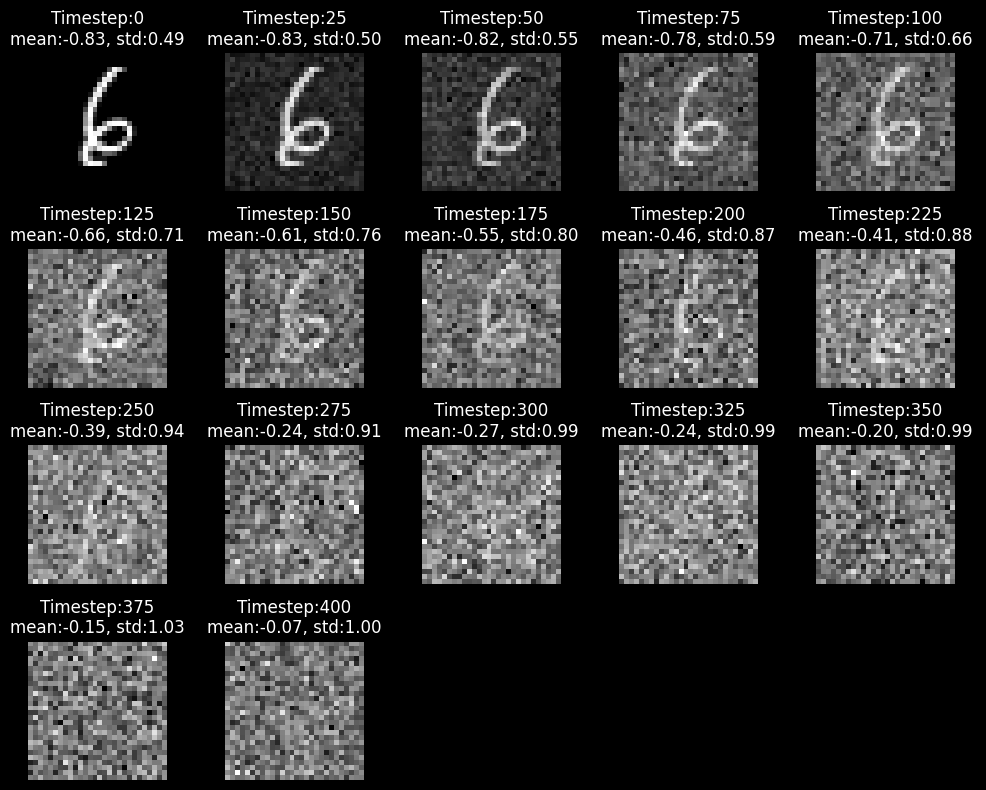

In [8]:
eg = next(iter(DataLoader(trainset).iter_batches(1)))

def show_diffusion():
    # Determine the timesteps at which to display the images
    timesteps = list(range(0, config.num_timesteps + 1, 25))

    # Determine number of rows and columns for the grid
    n_cols = 5  # Set the number of columns you want
    n_rows = math.ceil(len(timesteps) / n_cols)

    # Create subplots based on the number of images to display
    plt.style.use('dark_background')  
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

    # Flatten axes array for easy indexing if n_rows > 1
    axes = axes.flatten() if n_rows > 1 else [axes]

    for idx, (i, ax) in enumerate(zip(timesteps, axes)):
        noisy_image, noise = DiffusionUtils(config).noisy_it(eg[0], torch.tensor([i]).to(config.device))
        plt_image = noisy_image["noisy_images"].squeeze()
        
        # Display image in the subplot
        ax.imshow(plt_image.cpu(), cmap="gray")
        ax.set_title(f"Timestep:{i}\nmean:{plt_image.mean().item():.2f}, std:{plt_image.std().item():.2f}")
        ax.axis('off')  # Hide axis labels

    # Turn off any unused subplots
    for j in range(len(timesteps), len(axes)):
        axes[j].axis('off')

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()

show_diffusion()

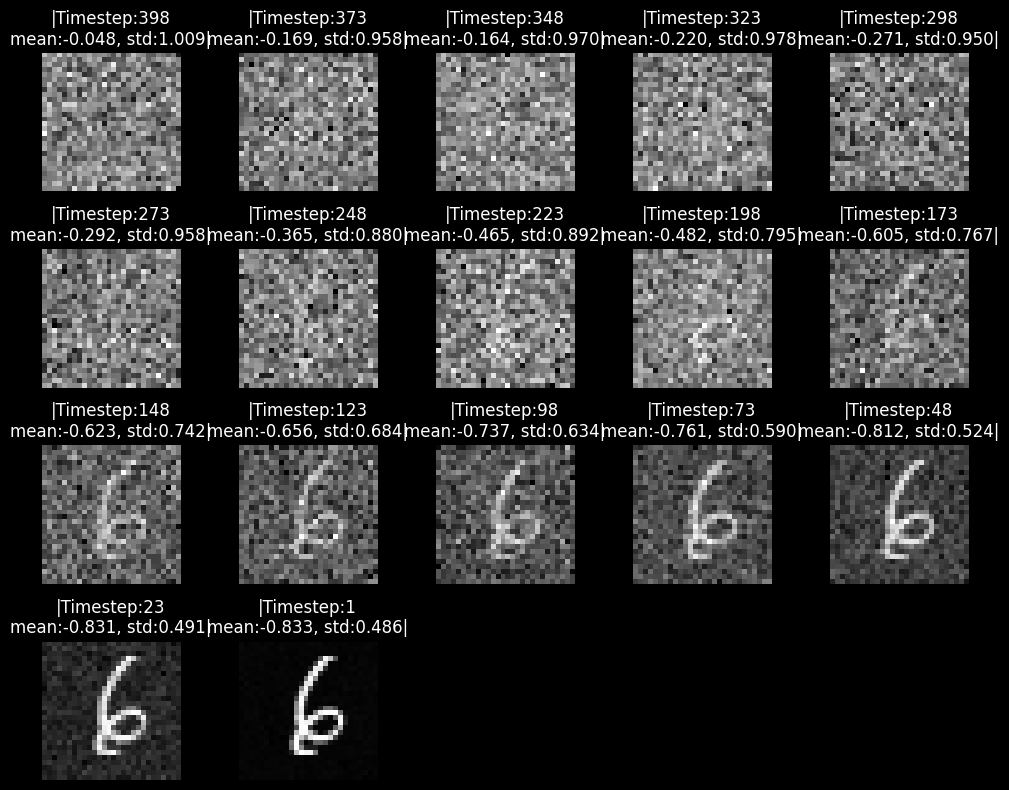

In [9]:
# test `generate` (using noisy_images, noise and timesteps)
def show_generation_from_noise():
    noisy_images, noises, times = [], [], {}
    for idx, i in enumerate(range(0, config.num_timesteps-1)):
        noisy_image, noise = DiffusionUtils(config).noisy_it(eg[0], torch.tensor([i]).to(config.device))
        noisy_images.append(noisy_image["noisy_images"].squeeze())
        noises.append(noise.squeeze())
        times[idx] = i

    # Filter the timesteps for which images will be displayed
    plot_indices = [i for i, t in enumerate(list(reversed(times))[:-1]) if i % 25 == 0 or i == len(times) - 2]

    # Determine number of rows and columns for the grid
    n_cols = 5  # Set the number of columns you want
    n_rows = math.ceil(len(plot_indices) / n_cols)

    # Create subplots based on the number of images to display
    plt.style.use('dark_background')
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

    # Flatten axes array for easy indexing if n_rows > 1
    axes = axes.flatten() if n_rows > 1 else [axes]

    for i, ax in zip(plot_indices, axes):
        t = list(reversed(times))[:-1][i]
        img = DiffusionUtils(config).one_step_ddpm(xt=noisy_images[t], pred_noise=noises[t], t=t)
        
        # Display image in the subplot
        ax.imshow(img.squeeze().cpu(), cmap="gray")
        ax.set_title(f"|Timestep:{t}\nmean:{img.mean().item():.3f}, std:{img.std().item():.3f}|")
        ax.axis('off')  # Hide axis labels

    # Turn off any unused subplots
    for j in range(len(plot_indices), len(axes)):
        axes[j].axis('off')

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()

show_generation_from_noise()

# Diffusion Transformer (from official repo)

In [10]:
def modulate(x, shift, scale):
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False, extra_tokens=0):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token and extra_tokens > 0:
        pos_embed = np.concatenate([np.zeros([extra_tokens, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

In [11]:
class TimestepEmbedder(nn.Module):
    """
    Embeds scalar timesteps into vector representations.
    """
    def __init__(self, hidden_size, frequency_embedding_size=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size, bias=True),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size, bias=True),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):
        """
        Create sinusoidal timestep embeddings.
        :param t: a 1-D Tensor of N indices, one per batch element.
                          These may be fractional.
        :param dim: the dimension of the output.
        :param max_period: controls the minimum frequency of the embeddings.
        :return: an (N, D) Tensor of positional embeddings.
        """
        # https://github.com/openai/glide-text2im/blob/main/glide_text2im/nn.py
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
        ).to(device=t.device)
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding

    def forward(self, t):
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size)
        t_emb = self.mlp(t_freq)
        return t_emb

In [12]:
class LabelEmbedder(nn.Module):
    """
    Embeds class labels into vector representations. Also handles label dropout for classifier-free guidance.
    """
    def __init__(self, num_classes, hidden_size, dropout_prob):
        super().__init__()
        use_cfg_embedding = dropout_prob > 0
        self.embedding_table = nn.Embedding(num_classes + use_cfg_embedding, hidden_size)
        self.num_classes = num_classes
        self.dropout_prob = dropout_prob

    def token_drop(self, labels, force_drop_ids=None):
        """
        Drops labels to enable classifier-free guidance.
        """
        if force_drop_ids is None:
            drop_ids = torch.rand(labels.shape[0], device=labels.device) < self.dropout_prob
        else:
            drop_ids = force_drop_ids == 1
        labels = torch.where(drop_ids, self.num_classes, labels)
        return labels

    def forward(self, labels, train, force_drop_ids=None):
        use_dropout = self.dropout_prob > 0
        if (train and use_dropout) or (force_drop_ids is not None):
            labels = self.token_drop(labels, force_drop_ids)
        embeddings = self.embedding_table(labels)
        return embeddings

In [13]:
class LabelEmbedder(nn.Module):
    """
    Embeds class labels into vector representations. Also handles label dropout for classifier-free guidance.
    """
    def __init__(self, num_classes, hidden_size, dropout_prob):
        super().__init__()
        use_cfg_embedding = dropout_prob > 0
        self.embedding_table = nn.Embedding(num_classes + use_cfg_embedding, hidden_size)
        self.num_classes = num_classes
        self.dropout_prob = dropout_prob

    def token_drop(self, labels, force_drop_ids=None):
        """
        Drops labels to enable classifier-free guidance.
        """
        if force_drop_ids is None:
            drop_ids = torch.rand(labels.shape[0], device=labels.device) < self.dropout_prob
        else:
            drop_ids = force_drop_ids == 1
        labels = torch.where(drop_ids, self.num_classes, labels)
        return labels

    def forward(self, labels, train, force_drop_ids=None):
        use_dropout = self.dropout_prob > 0
        if (train and use_dropout) or (force_drop_ids is not None):
            labels = self.token_drop(labels, force_drop_ids)
        embeddings = self.embedding_table(labels)
        return embeddings

In [14]:
class Attention(nn.Module):
    def __init__(
            self,
            dim: int,
            num_heads: int = 8,
            qkv_bias: bool = False,
            qk_norm: bool = False,
            attn_drop: float = 0.,
            proj_drop: float = 0.,
            norm_layer: nn.Module = nn.LayerNorm,
    ) -> None:
        super().__init__()
        assert dim % num_heads == 0, 'dim should be divisible by num_heads'
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.q_norm = norm_layer(self.head_dim) if qk_norm else nn.Identity()
        self.k_norm = norm_layer(self.head_dim) if qk_norm else nn.Identity()
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)
        q, k = self.q_norm(q), self.k_norm(k)

        x = F.scaled_dot_product_attention(
            q, k, v,
            dropout_p=self.attn_drop.p if self.training else 0.,
        )

        x = x.transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [15]:
class Mlp(nn.Module):
    """ MLP as used in Vision Transformer, MLP-Mixer and related networks
    """
    def __init__(
            self,
            in_features,
            hidden_features=None,
            out_features=None,
            act_layer=nn.GELU,
            norm_layer=None,
            bias=True,
            drop=0.,
            use_conv=False,
    ):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        bias = (bias, bias)
        drop_probs = (drop, drop)
        linear_layer = partial(nn.Conv2d, kernel_size=1) if use_conv else nn.Linear

        self.fc1 = linear_layer(in_features, hidden_features, bias=bias[0])
        self.act = act_layer()
        self.drop1 = nn.Dropout(drop_probs[0])
        self.norm = norm_layer(hidden_features) if norm_layer is not None else nn.Identity()
        self.fc2 = linear_layer(hidden_features, out_features, bias=bias[1])
        self.drop2 = nn.Dropout(drop_probs[1])

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop1(x)
        x = self.norm(x)
        x = self.fc2(x)
        x = self.drop2(x)
        return x

In [16]:
class Format(str, Enum):
    NCHW = 'NCHW'
    NHWC = 'NHWC'
    NCL = 'NCL'
    NLC = 'NLC'

def nchw_to(x: torch.Tensor, fmt: Format):
    if fmt == Format.NHWC:
        x = x.permute(0, 2, 3, 1)
    elif fmt == Format.NLC:
        x = x.flatten(2).transpose(1, 2)
    elif fmt == Format.NCL:
        x = x.flatten(2)
    return x

_logger = logging.getLogger(__name__)

def resample_patch_embed(
        patch_embed,
        new_size: List[int],
        interpolation: str = 'bicubic',
        antialias: bool = True,
        verbose: bool = False,
):
    """Resample the weights of the patch embedding kernel to target resolution.
    We resample the patch embedding kernel by approximately inverting the effect
    of patch resizing.

    Code based on:
      https://github.com/google-research/big_vision/blob/b00544b81f8694488d5f36295aeb7972f3755ffe/big_vision/models/proj/flexi/vit.py

    With this resizing, we can for example load a B/8 filter into a B/16 model
    and, on 2x larger input image, the result will match.

    Args:
        patch_embed: original parameter to be resized.
        new_size (tuple(int, int): target shape (height, width)-only.
        interpolation (str): interpolation for resize
        antialias (bool): use anti-aliasing filter in resize
        verbose (bool): log operation
    Returns:
        Resized patch embedding kernel.
    """
    import numpy as np
    try:
        from torch import vmap
    except ImportError:
        from functorch import vmap

    assert len(patch_embed.shape) == 4, "Four dimensions expected"
    assert len(new_size) == 2, "New shape should only be hw"
    old_size = patch_embed.shape[-2:]
    if tuple(old_size) == tuple(new_size):
        return patch_embed

    if verbose:
        _logger.info(f"Resize patch embedding {patch_embed.shape} to {new_size}, w/ {interpolation} interpolation.")

    def resize(x_np, _new_size):
        x_tf = torch.Tensor(x_np)[None, None, ...]
        x_upsampled = F.interpolate(
            x_tf, size=_new_size, mode=interpolation, antialias=antialias)[0, 0, ...].numpy()
        return x_upsampled

    def get_resize_mat(_old_size, _new_size):
        mat = []
        for i in range(np.prod(_old_size)):
            basis_vec = np.zeros(_old_size)
            basis_vec[np.unravel_index(i, _old_size)] = 1.
            mat.append(resize(basis_vec, _new_size).reshape(-1))
        return np.stack(mat).T

    resize_mat = get_resize_mat(old_size, new_size)
    resize_mat_pinv = torch.tensor(np.linalg.pinv(resize_mat.T), device=patch_embed.device)

    def resample_kernel(kernel):
        resampled_kernel = resize_mat_pinv @ kernel.reshape(-1)
        return resampled_kernel.reshape(new_size)

    v_resample_kernel = vmap(vmap(resample_kernel, 0, 0), 1, 1)
    orig_dtype = patch_embed.dtype
    patch_embed = patch_embed.float()
    patch_embed = v_resample_kernel(patch_embed)
    patch_embed = patch_embed.to(orig_dtype)
    return patch_embed

class PatchEmbed(nn.Module):
    """ 2D Image to Patch Embedding
    """
    dynamic_img_pad: torch.jit.Final[bool]

    def __init__(
            self,
            img_size: Optional[int] = 224,
            patch_size: int = 16,
            in_chans: int = 3,
            embed_dim: int = 768,
            norm_layer: Optional[Callable] = None,
            flatten: bool = True,
            output_fmt: Optional[str] = None,
            bias: bool = True,
            strict_img_size: bool = True,
            dynamic_img_pad: bool = False,
    ):
        super().__init__()
        self.patch_size = (patch_size, patch_size)
        self.img_size, self.grid_size, self.num_patches = self._init_img_size(img_size)

        if output_fmt is not None:
            self.flatten = False
            self.output_fmt = Format(output_fmt)
        else:
            # flatten spatial dim and transpose to channels last, kept for bwd compat
            self.flatten = flatten
            self.output_fmt = Format.NCHW
        self.strict_img_size = strict_img_size
        self.dynamic_img_pad = dynamic_img_pad

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size, bias=bias)
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def _init_img_size(self, img_size: Union[int, Tuple[int, int]]):
        assert self.patch_size
        if img_size is None:
            return None, None, None
        img_size = (img_size, img_size)
        grid_size = tuple([s // p for s, p in zip(img_size, self.patch_size)])
        num_patches = grid_size[0] * grid_size[1]
        return img_size, grid_size, num_patches

    def set_input_size(
            self,
            img_size: Optional[Union[int, Tuple[int, int]]] = None,
            patch_size: Optional[Union[int, Tuple[int, int]]] = None,
    ):
        new_patch_size = None
        if patch_size is not None:
            new_patch_size = (patch_size, patch_size)
        if new_patch_size is not None and new_patch_size != self.patch_size:
            with torch.no_grad():
                new_proj = nn.Conv2d(
                    self.proj.in_channels,
                    self.proj.out_channels,
                    kernel_size=new_patch_size,
                    stride=new_patch_size,
                    bias=self.proj.bias is not None,
                )
                new_proj.weight.copy_(resample_patch_embed(self.proj.weight, new_patch_size, verbose=True))
                if self.proj.bias is not None:
                    new_proj.bias.copy_(self.proj.bias)
                self.proj = new_proj
            self.patch_size = new_patch_size
        img_size = img_size or self.img_size
        if img_size != self.img_size or new_patch_size is not None:
            self.img_size, self.grid_size, self.num_patches = self._init_img_size(img_size)

    def feat_ratio(self, as_scalar=True) -> Union[Tuple[int, int], int]:
        if as_scalar:
            return max(self.patch_size)
        else:
            return self.patch_size

    def dynamic_feat_size(self, img_size: Tuple[int, int]) -> Tuple[int, int]:
        """ Get grid (feature) size for given image size taking account of dynamic padding.
        NOTE: must be torchscript compatible so using fixed tuple indexing
        """
        if self.dynamic_img_pad:
            return math.ceil(img_size[0] / self.patch_size[0]), math.ceil(img_size[1] / self.patch_size[1])
        else:
            return img_size[0] // self.patch_size[0], img_size[1] // self.patch_size[1]

    def forward(self, x):
        B, C, H, W = x.shape
        if self.img_size is not None:
            if self.strict_img_size:
                _assert(H == self.img_size[0], f"Input height ({H}) doesn't match model ({self.img_size[0]}).")
                _assert(W == self.img_size[1], f"Input width ({W}) doesn't match model ({self.img_size[1]}).")
            elif not self.dynamic_img_pad:
                _assert(
                    H % self.patch_size[0] == 0,
                    f"Input height ({H}) should be divisible by patch size ({self.patch_size[0]})."
                )
                _assert(
                    W % self.patch_size[1] == 0,
                    f"Input width ({W}) should be divisible by patch size ({self.patch_size[1]})."
                )
        if self.dynamic_img_pad:
            pad_h = (self.patch_size[0] - H % self.patch_size[0]) % self.patch_size[0]
            pad_w = (self.patch_size[1] - W % self.patch_size[1]) % self.patch_size[1]
            x = F.pad(x, (0, pad_w, 0, pad_h))
        x = self.proj(x)
        if self.flatten:
            x = x.flatten(2).transpose(1, 2)  # NCHW -> NLC
        elif self.output_fmt != Format.NCHW:
            x = nchw_to(x, self.output_fmt)
        x = self.norm(x)
        return x

In [17]:
class DiTBlock(nn.Module):
    """
    A DiT block with adaptive layer norm zero (adaLN-Zero) conditioning.
    """
    def __init__(self, hidden_size, num_heads, mlp_ratio=4.0, **block_kwargs):
        super().__init__()
        self.norm1 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.attn = Attention(hidden_size, num_heads=num_heads, qkv_bias=True, **block_kwargs)
        self.norm2 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        mlp_hidden_dim = int(hidden_size * mlp_ratio)
        approx_gelu = lambda: nn.GELU(approximate="tanh")
        self.mlp = Mlp(in_features=hidden_size, hidden_features=mlp_hidden_dim, act_layer=approx_gelu, drop=0)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size, 6 * hidden_size, bias=True)
        )

    def forward(self, x, c):
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = self.adaLN_modulation(c).chunk(6, dim=1)
        x = x + gate_msa.unsqueeze(1) * self.attn(modulate(self.norm1(x), shift_msa, scale_msa))
        x = x + gate_mlp.unsqueeze(1) * self.mlp(modulate(self.norm2(x), shift_mlp, scale_mlp))
        return x

In [18]:
class FinalLayer(nn.Module):
    """
    The final layer of DiT.
    """
    def __init__(self, hidden_size, patch_size, out_channels):
        super().__init__()
        self.norm_final = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.linear = nn.Linear(hidden_size, patch_size * patch_size * out_channels, bias=True)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size, 2 * hidden_size, bias=True)
        )

    def forward(self, x, c):
        shift, scale = self.adaLN_modulation(c).chunk(2, dim=1)
        x = modulate(self.norm_final(x), shift, scale)
        x = self.linear(x)
        return x

In [19]:
class DiT(nn.Module):
    """
    Diffusion model with a Transformer backbone.
    """
    def __init__(
        self,
        input_size=32,
        patch_size=2,
        in_channels=4,
        hidden_size=1152,
        depth=28,
        num_heads=16,
        mlp_ratio=4.0,
        class_dropout_prob=0.1,
        num_classes=1000,
        learn_sigma=True,
    ):
        super().__init__()
        self.learn_sigma = learn_sigma
        self.in_channels = in_channels
        self.out_channels = in_channels * 2 if learn_sigma else in_channels
        self.patch_size = patch_size
        self.num_heads = num_heads

        self.x_embedder = PatchEmbed(input_size, patch_size, in_channels, hidden_size, bias=True)
        self.t_embedder = TimestepEmbedder(hidden_size)
        self.y_embedder = LabelEmbedder(num_classes, hidden_size, class_dropout_prob)
        num_patches = self.x_embedder.num_patches
        # Will use fixed sin-cos embedding:
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, hidden_size), requires_grad=False)

        self.blocks = nn.ModuleList([
            DiTBlock(hidden_size, num_heads, mlp_ratio=mlp_ratio) for _ in range(depth)
        ])
        self.final_layer = FinalLayer(hidden_size, patch_size, self.out_channels)
        self.initialize_weights()

    def initialize_weights(self):
        # Initialize transformer layers:
        def _basic_init(module):
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
        self.apply(_basic_init)

        # Initialize (and freeze) pos_embed by sin-cos embedding:
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.x_embedder.num_patches ** 0.5))
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        # Initialize patch_embed like nn.Linear (instead of nn.Conv2d):
        w = self.x_embedder.proj.weight.data
        nn.init.xavier_uniform_(w.view([w.shape[0], -1]))
        nn.init.constant_(self.x_embedder.proj.bias, 0)

        # Initialize label embedding table:
        nn.init.normal_(self.y_embedder.embedding_table.weight, std=0.02)

        # Initialize timestep embedding MLP:
        nn.init.normal_(self.t_embedder.mlp[0].weight, std=0.02)
        nn.init.normal_(self.t_embedder.mlp[2].weight, std=0.02)

        # Zero-out adaLN modulation layers in DiT blocks:
        for block in self.blocks:
            nn.init.constant_(block.adaLN_modulation[-1].weight, 0)
            nn.init.constant_(block.adaLN_modulation[-1].bias, 0)

        # Zero-out output layers:
        nn.init.constant_(self.final_layer.adaLN_modulation[-1].weight, 0)
        nn.init.constant_(self.final_layer.adaLN_modulation[-1].bias, 0)
        nn.init.constant_(self.final_layer.linear.weight, 0)
        nn.init.constant_(self.final_layer.linear.bias, 0)

    def unpatchify(self, x):
        """
        x: (N, T, patch_size**2 * C)
        imgs: (N, H, W, C)
        """
        c = self.out_channels
        p = self.x_embedder.patch_size[0]
        h = w = int(x.shape[1] ** 0.5)
        assert h * w == x.shape[1]

        x = x.reshape(shape=(x.shape[0], h, w, p, p, c))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], c, h * p, h * p))
        return imgs

    def forward(self, x, t, y):
        """
        Forward pass of DiT.
        x: (N, C, H, W) tensor of spatial inputs (images or latent representations of images)
        t: (N,) tensor of diffusion timesteps
        y: (N,) tensor of class labels
        """
        x = self.x_embedder(x) + self.pos_embed  # (N, T, D), where T = H * W / patch_size ** 2
        t = self.t_embedder(t)                   # (N, D)
        y = self.y_embedder(y, self.training)    # (N, D)
        c = t + y                                # (N, D)
        for block in self.blocks:
            x = block(x, c)                      # (N, T, D)
        x = self.final_layer(x, c)                # (N, T, patch_size ** 2 * out_channels)
        x = self.unpatchify(x)                   # (N, out_channels, H, W)
        return x

    def forward_with_cfg(self, x, t, y, cfg_scale):
        """
        Forward pass of DiT, but also batches the unconditional forward pass for classifier-free guidance.
        """
        # https://github.com/openai/glide-text2im/blob/main/notebooks/text2im.ipynb
        half = x[: len(x) // 2]
        combined = torch.cat([half, half], dim=0)
        model_out = self(combined, t, y)
        # For exact reproducibility reasons, we apply classifier-free guidance on only
        # three channels by default. The standard approach to cfg applies it to all channels.
        # This can be done by uncommenting the following line and commenting-out the line following that.
        # eps, rest = model_out[:, :self.in_channels], model_out[:, self.in_channels:]
        eps, rest = model_out[:, :3], model_out[:, 3:]
        cond_eps, uncond_eps = torch.split(eps, len(eps) // 2, dim=0)
        half_eps = uncond_eps + cfg_scale * (cond_eps - uncond_eps)
        eps = torch.cat([half_eps, half_eps], dim=0)
        return torch.cat([eps, rest], dim=1)
    
    def configure_optimizers(
        self,
        weight_decay:float,
        learning_rate:float,
        betas:tuple[float, float],
        device_type:str
    ):
        params_dict = {pname:p for pname, p in self.named_parameters() if p.requires_grad}

        # all weights except layernorms and biases, embeddings and linears
        decay_params = [p for pname, p in params_dict.items() if p.dim() >= 2]
        # layernorms and biases
        non_decay_params = [p for pname, p in params_dict.items() if p.dim() < 2]
        optim_groups = [
            {"params": decay_params, "weight_decay": weight_decay},
            {"params": non_decay_params, "weight_decay": 0.}
        ]

        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == "cuda"
        # other_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(
            params=optim_groups,
            lr=learning_rate,
            betas=betas,
            fused=False # getting error with fused=True
        )
        return optimizer

# Training (Not from official repo)

In [20]:
class CosineDecayWithWarmup:
    def __init__(
        self,
        warmup_steps:int,
        max_learning_rate:float,
        decay_steps:int,
        min_learning_rate:float
    ):
        self.warmup_steps = warmup_steps
        self.max_learning_rate = max_learning_rate
        self.decay_steps = decay_steps
        self.min_learning_rate = min_learning_rate

    def __call__(self, step):
        # linear warmup for warmup_steps steps
        if step < self.warmup_steps:
            return self.max_learning_rate * step / self.warmup_steps
        # if it > decay_steps, return min learning rate
        if step > self.decay_steps:
            return self.min_learning_rate
        # in between, use cosine decay down to min learning rate
        decay_ratio = (step - self.warmup_steps) / (self.decay_steps - self.warmup_steps)
        coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
        return self.min_learning_rate + coeff * (self.max_learning_rate - self.min_learning_rate)

In [21]:
model = DiT(
    input_size=config.H,
    patch_size=config.patch_size,
    in_channels=config.in_channels,
    hidden_size=config.d_model,
    depth=config.num_layers,
    num_heads=config.num_heads,
    mlp_ratio=4,
    class_dropout_prob=config.cfg_dropout_rate,
    num_classes=config.num_classes,
    learn_sigma=False
).to(config.device)

print(sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6, "Million Parameters\n")

with torch.no_grad():
    out = model(eg[0], torch.tensor([25]).to(config.device), torch.tensor([0]).to(config.device))
out.mean(), out.std(), out.min(), out.max(), eg[0].shape
del eg

9.31306 Million Parameters



In [23]:
get_lr = CosineDecayWithWarmup(
    warmup_steps=config.warmup_steps,
    max_learning_rate=config.max_lr,
    decay_steps=config.decay_steps,
    min_learning_rate=config.min_lr
) if not config.no_decay else lambda _: config.max_lr

train_iterator = iter(DataLoader(trainset).iter_batches(config.batch_size))
val_iterator = iter(DataLoader(valset).iter_batches(config.batch_size))

diff_utils = DiffusionUtils(config)

ctx = torch.autocast(
        device_type=config.device.type,
        dtype={"bfloat16": torch.bfloat16,
               "float32" : torch.float32}[config.dtype_type]
    )

optimizer = model.configure_optimizers(
    weight_decay=config.weight_decay,
    learning_rate=config.max_lr,
    betas=(config.beta1, config.beta2),
    device_type=config.device.type
)

In [24]:
@torch.no_grad()
def evaluate(model:nn.Module):
    model.eval()
    gen_image = diff_utils.generate(model=model, num_samples=1, labels=[random.randint(0, config.num_classes-1)])
    model.train()
    return gen_image.detach().cpu().squeeze()

| Step: 0 || Loss: 1.0014 || LR: 0.000000e+00 || dt: 125.67ms |
| Step: 50 || Loss: 0.2495 || LR: 5.000000e-04 || dt: 20.15ms |
| Step: 100 || Loss: 0.1277 || LR: 1.000000e-03 || dt: 19.37ms |
| Step: 150 || Loss: 0.0972 || LR: 9.999844e-04 || dt: 19.42ms |
| Step: 200 || Loss: 0.1264 || LR: 9.999377e-04 || dt: 19.33ms |
| Step: 250 || Loss: 0.1285 || LR: 9.998598e-04 || dt: 19.53ms |
| Step: 300 || Loss: 0.0823 || LR: 9.997508e-04 || dt: 19.31ms |
| Step: 350 || Loss: 0.0836 || LR: 9.996106e-04 || dt: 19.75ms |
Generating images of [3]


100%|██████████| 399/399 [00:00<00:00, 593.27it/s]


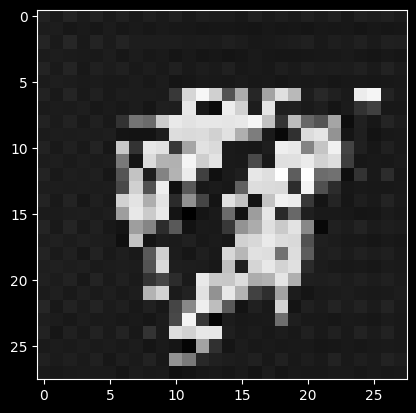

| Step: 400 || Loss: 0.1010 || LR: 9.994393e-04 || dt: 725.93ms |
| Step: 450 || Loss: 0.1240 || LR: 9.992369e-04 || dt: 19.44ms |
| Step: 500 || Loss: 0.0804 || LR: 9.990034e-04 || dt: 19.18ms |
| Step: 550 || Loss: 0.0672 || LR: 9.987388e-04 || dt: 18.97ms |
| Step: 600 || Loss: 0.0864 || LR: 9.984431e-04 || dt: 18.86ms |
| Step: 650 || Loss: 0.0624 || LR: 9.981164e-04 || dt: 19.19ms |
| Step: 700 || Loss: 0.0760 || LR: 9.977586e-04 || dt: 19.30ms |
| Step: 750 || Loss: 0.0558 || LR: 9.973699e-04 || dt: 19.55ms |
Generating images of [6]


100%|██████████| 399/399 [00:00<00:00, 589.82it/s]


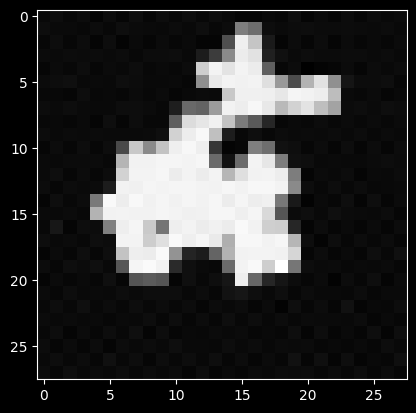

| Step: 800 || Loss: 0.0567 || LR: 9.969501e-04 || dt: 728.29ms |
| Step: 850 || Loss: 0.0488 || LR: 9.964993e-04 || dt: 19.13ms |
| Step: 900 || Loss: 0.0516 || LR: 9.960177e-04 || dt: 18.60ms |
| Step: 950 || Loss: 0.0521 || LR: 9.955051e-04 || dt: 18.99ms |
| Step: 1000 || Loss: 0.0416 || LR: 9.949617e-04 || dt: 19.13ms |
| Step: 1050 || Loss: 0.0565 || LR: 9.943874e-04 || dt: 18.76ms |
| Step: 1100 || Loss: 0.0534 || LR: 9.937823e-04 || dt: 19.26ms |
| Step: 1150 || Loss: 0.0552 || LR: 9.931464e-04 || dt: 19.33ms |
Generating images of [6]


100%|██████████| 399/399 [00:00<00:00, 596.58it/s]


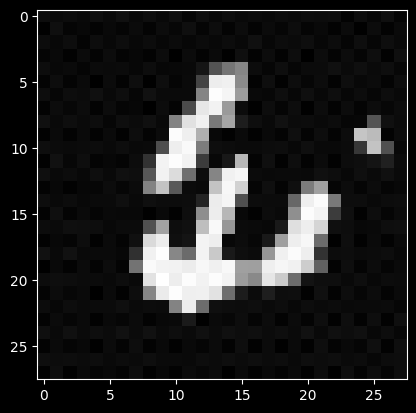

| Step: 1200 || Loss: 0.0634 || LR: 9.924798e-04 || dt: 720.83ms |
| Step: 1250 || Loss: 0.0526 || LR: 9.917826e-04 || dt: 19.37ms |
| Step: 1300 || Loss: 0.0500 || LR: 9.910547e-04 || dt: 19.49ms |
| Step: 1350 || Loss: 0.0280 || LR: 9.902962e-04 || dt: 19.48ms |
| Step: 1400 || Loss: 0.0369 || LR: 9.895071e-04 || dt: 19.31ms |
| Step: 1450 || Loss: 0.0626 || LR: 9.886876e-04 || dt: 19.56ms |
| Step: 1500 || Loss: 0.0426 || LR: 9.878375e-04 || dt: 19.33ms |
| Step: 1550 || Loss: 0.0506 || LR: 9.869572e-04 || dt: 19.88ms |
Generating images of [5]


100%|██████████| 399/399 [00:00<00:00, 589.07it/s]


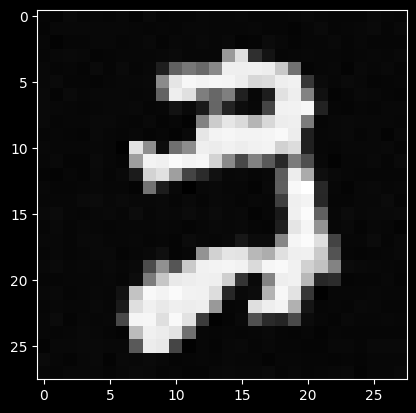

| Step: 1600 || Loss: 0.0480 || LR: 9.860464e-04 || dt: 728.10ms |
| Step: 1650 || Loss: 0.0464 || LR: 9.851054e-04 || dt: 18.95ms |
| Step: 1700 || Loss: 0.0482 || LR: 9.841342e-04 || dt: 19.17ms |
| Step: 1750 || Loss: 0.0580 || LR: 9.831327e-04 || dt: 18.98ms |
| Step: 1800 || Loss: 0.0439 || LR: 9.821012e-04 || dt: 20.36ms |
| Step: 1850 || Loss: 0.0408 || LR: 9.810397e-04 || dt: 18.41ms |
| Step: 1900 || Loss: 0.0435 || LR: 9.799482e-04 || dt: 19.80ms |
| Step: 1950 || Loss: 0.0655 || LR: 9.788267e-04 || dt: 19.09ms |
Generating images of [0]


100%|██████████| 399/399 [00:00<00:00, 588.16it/s]


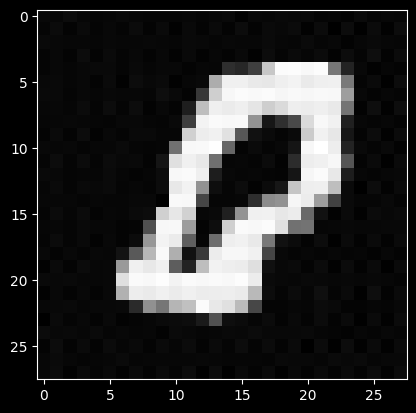

| Step: 2000 || Loss: 0.0421 || LR: 9.776755e-04 || dt: 731.62ms |
| Step: 2050 || Loss: 0.0377 || LR: 9.764945e-04 || dt: 18.98ms |
| Step: 2100 || Loss: 0.0346 || LR: 9.752837e-04 || dt: 19.16ms |
| Step: 2150 || Loss: 0.0487 || LR: 9.740434e-04 || dt: 19.28ms |
| Step: 2200 || Loss: 0.0367 || LR: 9.727736e-04 || dt: 19.44ms |
| Step: 2250 || Loss: 0.0441 || LR: 9.714742e-04 || dt: 18.95ms |
| Step: 2300 || Loss: 0.0519 || LR: 9.701456e-04 || dt: 19.02ms |
| Step: 2350 || Loss: 0.0361 || LR: 9.687876e-04 || dt: 19.48ms |
Generating images of [7]


100%|██████████| 399/399 [00:00<00:00, 595.76it/s]


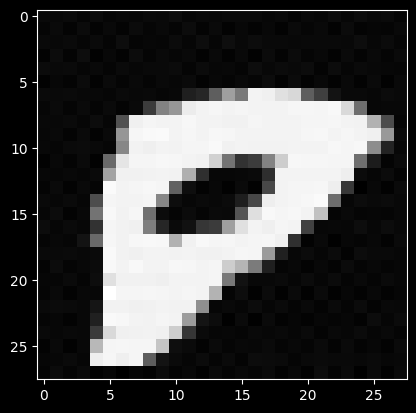

| Step: 2400 || Loss: 0.0577 || LR: 9.674004e-04 || dt: 721.13ms |
| Step: 2450 || Loss: 0.0345 || LR: 9.659841e-04 || dt: 19.52ms |
| Step: 2500 || Loss: 0.0388 || LR: 9.645387e-04 || dt: 19.24ms |
| Step: 2550 || Loss: 0.0340 || LR: 9.630644e-04 || dt: 19.38ms |
| Step: 2600 || Loss: 0.0318 || LR: 9.615613e-04 || dt: 19.48ms |
| Step: 2650 || Loss: 0.0484 || LR: 9.600294e-04 || dt: 19.32ms |
| Step: 2700 || Loss: 0.0399 || LR: 9.584688e-04 || dt: 19.23ms |
| Step: 2750 || Loss: 0.0422 || LR: 9.568797e-04 || dt: 19.21ms |
Generating images of [9]


100%|██████████| 399/399 [00:00<00:00, 585.08it/s]


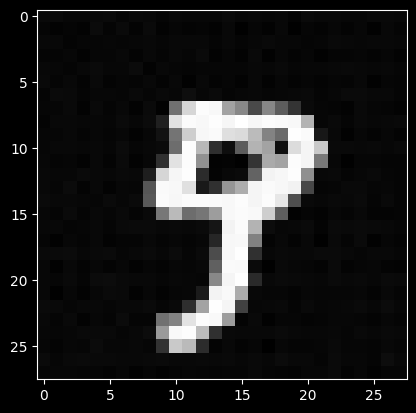

| Step: 2800 || Loss: 0.0385 || LR: 9.552621e-04 || dt: 735.01ms |
| Step: 2850 || Loss: 0.0394 || LR: 9.536161e-04 || dt: 19.25ms |
| Step: 2900 || Loss: 0.0408 || LR: 9.519419e-04 || dt: 19.48ms |
| Step: 2950 || Loss: 0.0387 || LR: 9.502395e-04 || dt: 18.79ms |
| Step: 3000 || Loss: 0.0544 || LR: 9.485091e-04 || dt: 18.77ms |
| Step: 3050 || Loss: 0.0374 || LR: 9.467507e-04 || dt: 18.77ms |
| Step: 3100 || Loss: 0.0481 || LR: 9.449645e-04 || dt: 19.29ms |
| Step: 3150 || Loss: 0.0365 || LR: 9.431505e-04 || dt: 18.97ms |
Generating images of [4]


100%|██████████| 399/399 [00:00<00:00, 580.61it/s]


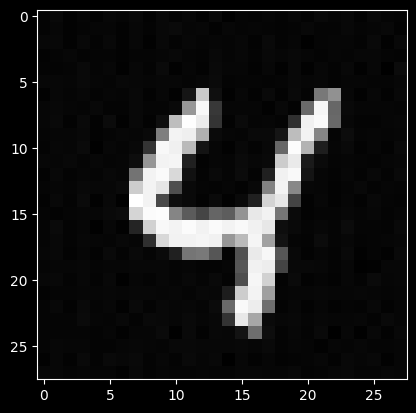

| Step: 3200 || Loss: 0.0408 || LR: 9.413090e-04 || dt: 740.47ms |
| Step: 3250 || Loss: 0.0365 || LR: 9.394399e-04 || dt: 18.65ms |
| Step: 3300 || Loss: 0.0322 || LR: 9.375435e-04 || dt: 19.61ms |
| Step: 3350 || Loss: 0.0586 || LR: 9.356198e-04 || dt: 19.70ms |
| Step: 3400 || Loss: 0.0418 || LR: 9.336690e-04 || dt: 19.30ms |
| Step: 3450 || Loss: 0.0463 || LR: 9.316911e-04 || dt: 19.55ms |
| Step: 3500 || Loss: 0.0377 || LR: 9.296864e-04 || dt: 21.26ms |
| Step: 3550 || Loss: 0.0553 || LR: 9.276549e-04 || dt: 18.93ms |
Generating images of [9]


100%|██████████| 399/399 [00:00<00:00, 588.25it/s]


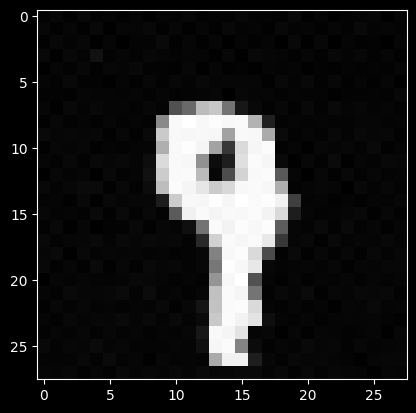

| Step: 3600 || Loss: 0.0468 || LR: 9.255967e-04 || dt: 728.90ms |
| Step: 3650 || Loss: 0.0364 || LR: 9.235120e-04 || dt: 18.73ms |
| Step: 3700 || Loss: 0.0323 || LR: 9.214009e-04 || dt: 19.24ms |
| Step: 3750 || Loss: 0.0385 || LR: 9.192636e-04 || dt: 19.12ms |
| Step: 3800 || Loss: 0.0375 || LR: 9.171002e-04 || dt: 19.22ms |
| Step: 3850 || Loss: 0.0452 || LR: 9.149107e-04 || dt: 19.08ms |
| Step: 3900 || Loss: 0.0446 || LR: 9.126954e-04 || dt: 18.92ms |
| Step: 3950 || Loss: 0.0383 || LR: 9.104544e-04 || dt: 19.69ms |
Generating images of [6]


100%|██████████| 399/399 [00:00<00:00, 571.35it/s]


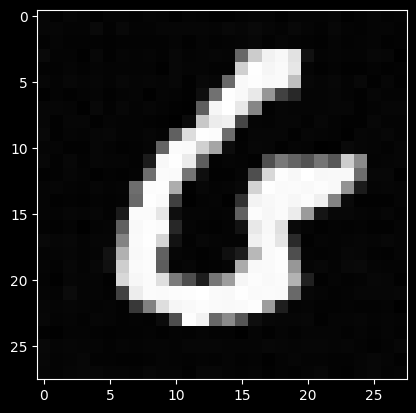

| Step: 4000 || Loss: 0.0341 || LR: 9.081879e-04 || dt: 751.59ms |
| Step: 4050 || Loss: 0.0466 || LR: 9.058959e-04 || dt: 19.56ms |
| Step: 4100 || Loss: 0.0338 || LR: 9.035786e-04 || dt: 19.31ms |
| Step: 4150 || Loss: 0.0307 || LR: 9.012361e-04 || dt: 19.58ms |
| Step: 4200 || Loss: 0.0377 || LR: 8.988687e-04 || dt: 19.36ms |
| Step: 4250 || Loss: 0.0349 || LR: 8.964764e-04 || dt: 18.84ms |
| Step: 4300 || Loss: 0.0363 || LR: 8.940594e-04 || dt: 19.41ms |
| Step: 4350 || Loss: 0.0430 || LR: 8.916178e-04 || dt: 19.35ms |
Generating images of [3]


100%|██████████| 399/399 [00:00<00:00, 596.61it/s]


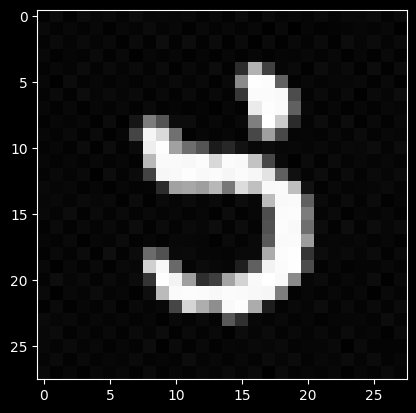

| Step: 4400 || Loss: 0.0327 || LR: 8.891519e-04 || dt: 720.25ms |
| Step: 4450 || Loss: 0.0358 || LR: 8.866617e-04 || dt: 18.62ms |
| Step: 4500 || Loss: 0.0619 || LR: 8.841474e-04 || dt: 19.14ms |
| Step: 4550 || Loss: 0.0444 || LR: 8.816092e-04 || dt: 19.06ms |
| Step: 4600 || Loss: 0.0411 || LR: 8.790472e-04 || dt: 19.48ms |
| Step: 4650 || Loss: 0.0386 || LR: 8.764615e-04 || dt: 19.19ms |
| Step: 4700 || Loss: 0.0381 || LR: 8.738525e-04 || dt: 19.56ms |
| Step: 4750 || Loss: 0.0363 || LR: 8.712201e-04 || dt: 19.70ms |
Generating images of [1]


100%|██████████| 399/399 [00:00<00:00, 590.90it/s]


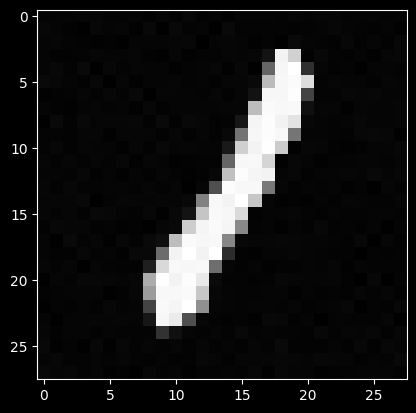

| Step: 4800 || Loss: 0.0331 || LR: 8.685646e-04 || dt: 727.86ms |
| Step: 4850 || Loss: 0.0395 || LR: 8.658861e-04 || dt: 18.83ms |
| Step: 4900 || Loss: 0.0346 || LR: 8.631849e-04 || dt: 18.85ms |
| Step: 4950 || Loss: 0.0376 || LR: 8.604610e-04 || dt: 18.88ms |
| Step: 5000 || Loss: 0.0266 || LR: 8.577146e-04 || dt: 18.70ms |
| Step: 5050 || Loss: 0.0301 || LR: 8.549460e-04 || dt: 18.65ms |
| Step: 5100 || Loss: 0.0348 || LR: 8.521553e-04 || dt: 19.85ms |
| Step: 5150 || Loss: 0.0422 || LR: 8.493426e-04 || dt: 19.49ms |
Generating images of [3]


100%|██████████| 399/399 [00:00<00:00, 587.73it/s]


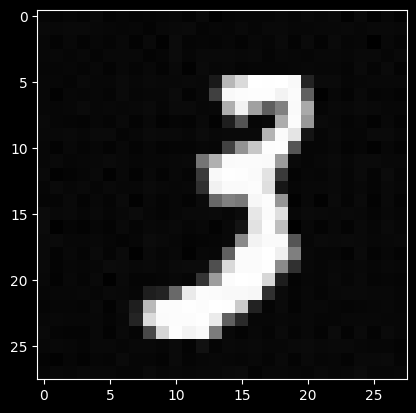

| Step: 5200 || Loss: 0.0403 || LR: 8.465081e-04 || dt: 729.27ms |
| Step: 5250 || Loss: 0.0302 || LR: 8.436521e-04 || dt: 19.25ms |
| Step: 5300 || Loss: 0.0350 || LR: 8.407746e-04 || dt: 19.07ms |
| Step: 5350 || Loss: 0.0588 || LR: 8.378759e-04 || dt: 19.17ms |
| Step: 5400 || Loss: 0.0423 || LR: 8.349562e-04 || dt: 18.84ms |
| Step: 5450 || Loss: 0.0353 || LR: 8.320156e-04 || dt: 19.08ms |
| Step: 5500 || Loss: 0.0560 || LR: 8.290543e-04 || dt: 19.31ms |
| Step: 5550 || Loss: 0.0333 || LR: 8.260725e-04 || dt: 19.40ms |
Generating images of [1]


100%|██████████| 399/399 [00:00<00:00, 585.57it/s]


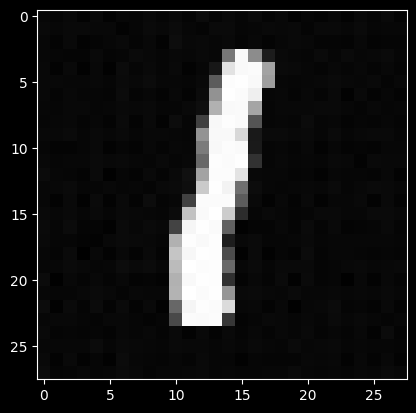

| Step: 5600 || Loss: 0.0512 || LR: 8.230704e-04 || dt: 855.70ms |
| Step: 5650 || Loss: 0.0442 || LR: 8.200481e-04 || dt: 19.16ms |
| Step: 5700 || Loss: 0.0328 || LR: 8.170059e-04 || dt: 19.52ms |
| Step: 5750 || Loss: 0.0317 || LR: 8.139440e-04 || dt: 19.15ms |
| Step: 5800 || Loss: 0.0493 || LR: 8.108625e-04 || dt: 19.55ms |
| Step: 5850 || Loss: 0.0388 || LR: 8.077616e-04 || dt: 19.42ms |
| Step: 5900 || Loss: 0.0303 || LR: 8.046416e-04 || dt: 19.57ms |
| Step: 5950 || Loss: 0.0385 || LR: 8.015026e-04 || dt: 19.04ms |
Generating images of [4]


100%|██████████| 399/399 [00:00<00:00, 576.05it/s]


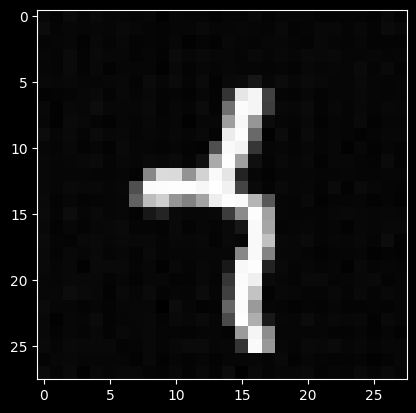

| Step: 6000 || Loss: 0.0377 || LR: 7.983447e-04 || dt: 744.88ms |
| Step: 6050 || Loss: 0.0363 || LR: 7.951683e-04 || dt: 19.42ms |
| Step: 6100 || Loss: 0.0436 || LR: 7.919736e-04 || dt: 19.09ms |
| Step: 6150 || Loss: 0.0323 || LR: 7.887606e-04 || dt: 19.52ms |
| Step: 6200 || Loss: 0.0499 || LR: 7.855296e-04 || dt: 19.27ms |
| Step: 6250 || Loss: 0.0361 || LR: 7.822808e-04 || dt: 19.62ms |
| Step: 6300 || Loss: 0.0354 || LR: 7.790145e-04 || dt: 19.34ms |
| Step: 6350 || Loss: 0.0376 || LR: 7.757308e-04 || dt: 19.09ms |
Generating images of [7]


100%|██████████| 399/399 [00:00<00:00, 600.49it/s]


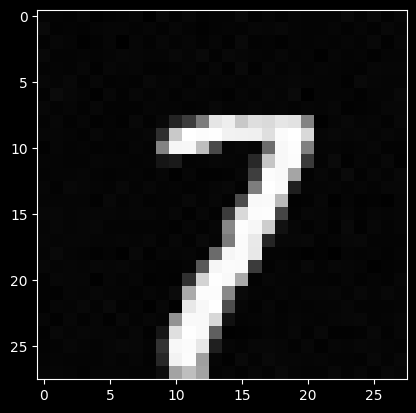

| Step: 6400 || Loss: 0.0378 || LR: 7.724298e-04 || dt: 716.02ms |
| Step: 6450 || Loss: 0.0356 || LR: 7.691120e-04 || dt: 18.84ms |
| Step: 6500 || Loss: 0.0325 || LR: 7.657773e-04 || dt: 18.70ms |
| Step: 6550 || Loss: 0.0351 || LR: 7.624261e-04 || dt: 19.43ms |
| Step: 6600 || Loss: 0.0280 || LR: 7.590585e-04 || dt: 18.96ms |
| Step: 6650 || Loss: 0.0363 || LR: 7.556748e-04 || dt: 19.12ms |
| Step: 6700 || Loss: 0.0352 || LR: 7.522752e-04 || dt: 18.75ms |
| Step: 6750 || Loss: 0.0339 || LR: 7.488598e-04 || dt: 20.26ms |
Generating images of [4]


100%|██████████| 399/399 [00:00<00:00, 560.95it/s]


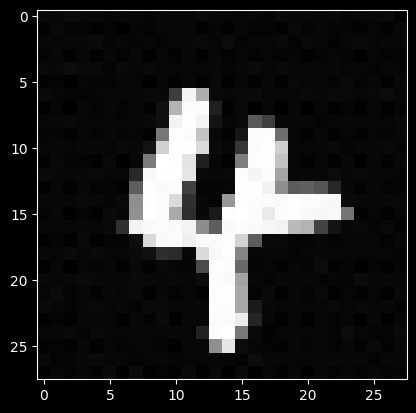

| Step: 6800 || Loss: 0.0388 || LR: 7.454290e-04 || dt: 763.55ms |
| Step: 6850 || Loss: 0.0504 || LR: 7.419828e-04 || dt: 19.66ms |
| Step: 6900 || Loss: 0.0417 || LR: 7.385216e-04 || dt: 19.61ms |
| Step: 6950 || Loss: 0.0352 || LR: 7.350455e-04 || dt: 19.33ms |
| Step: 7000 || Loss: 0.0432 || LR: 7.315547e-04 || dt: 18.95ms |
| Step: 7050 || Loss: 0.0399 || LR: 7.280496e-04 || dt: 19.04ms |
| Step: 7100 || Loss: 0.0333 || LR: 7.245302e-04 || dt: 18.84ms |
| Step: 7150 || Loss: 0.0398 || LR: 7.209968e-04 || dt: 19.17ms |
Generating images of [4]


100%|██████████| 399/399 [00:00<00:00, 587.64it/s]


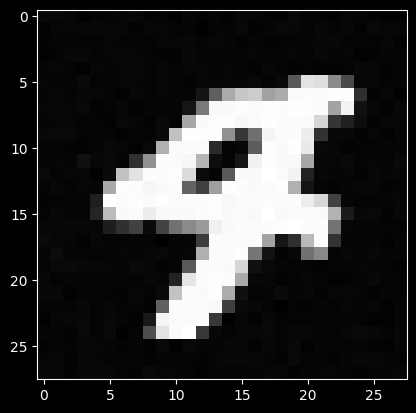

| Step: 7200 || Loss: 0.0331 || LR: 7.174497e-04 || dt: 730.98ms |
| Step: 7250 || Loss: 0.0321 || LR: 7.138890e-04 || dt: 19.39ms |
| Step: 7300 || Loss: 0.0368 || LR: 7.103150e-04 || dt: 19.60ms |
| Step: 7350 || Loss: 0.0340 || LR: 7.067279e-04 || dt: 19.00ms |
| Step: 7400 || Loss: 0.0359 || LR: 7.031279e-04 || dt: 19.01ms |
| Step: 7450 || Loss: 0.0293 || LR: 6.995153e-04 || dt: 19.01ms |
| Step: 7500 || Loss: 0.0520 || LR: 6.958902e-04 || dt: 19.31ms |
| Step: 7550 || Loss: 0.0336 || LR: 6.922529e-04 || dt: 19.28ms |
Generating images of [7]


100%|██████████| 399/399 [00:00<00:00, 574.46it/s]


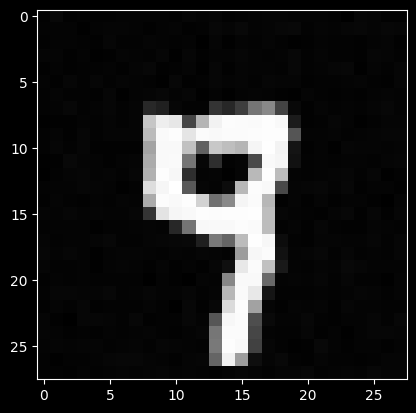

| Step: 7600 || Loss: 0.0508 || LR: 6.886037e-04 || dt: 748.48ms |
| Step: 7650 || Loss: 0.0385 || LR: 6.849426e-04 || dt: 18.72ms |
| Step: 7700 || Loss: 0.0337 || LR: 6.812701e-04 || dt: 19.67ms |
| Step: 7750 || Loss: 0.0348 || LR: 6.775863e-04 || dt: 18.75ms |
| Step: 7800 || Loss: 0.0368 || LR: 6.738914e-04 || dt: 19.25ms |
| Step: 7850 || Loss: 0.0323 || LR: 6.701857e-04 || dt: 19.10ms |
| Step: 7900 || Loss: 0.0329 || LR: 6.664693e-04 || dt: 19.09ms |
| Step: 7950 || Loss: 0.0657 || LR: 6.627426e-04 || dt: 19.10ms |
Generating images of [6]


100%|██████████| 399/399 [00:00<00:00, 598.04it/s]


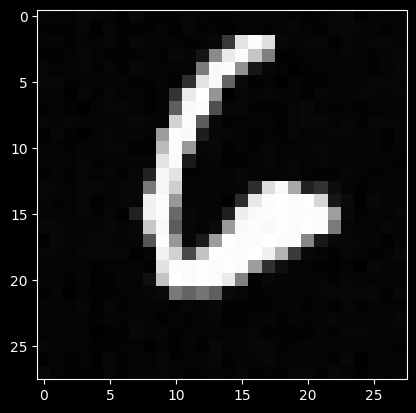

| Step: 8000 || Loss: 0.0399 || LR: 6.590058e-04 || dt: 719.05ms |
| Step: 8050 || Loss: 0.0338 || LR: 6.552590e-04 || dt: 19.22ms |
| Step: 8100 || Loss: 0.0307 || LR: 6.515026e-04 || dt: 19.02ms |
| Step: 8150 || Loss: 0.0490 || LR: 6.477367e-04 || dt: 19.09ms |
| Step: 8200 || Loss: 0.0310 || LR: 6.439617e-04 || dt: 19.19ms |
| Step: 8250 || Loss: 0.0304 || LR: 6.401776e-04 || dt: 19.18ms |
| Step: 8300 || Loss: 0.0330 || LR: 6.363848e-04 || dt: 19.89ms |
| Step: 8350 || Loss: 0.0348 || LR: 6.325836e-04 || dt: 18.89ms |
Generating images of [3]


100%|██████████| 399/399 [00:00<00:00, 592.05it/s]


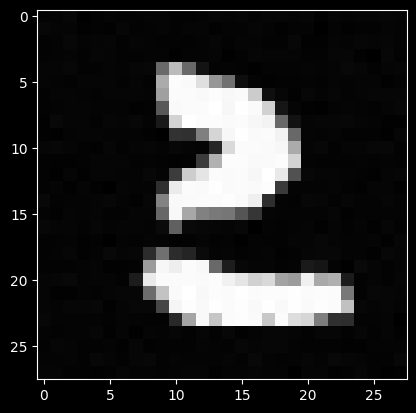

| Step: 8400 || Loss: 0.0288 || LR: 6.287740e-04 || dt: 726.36ms |
| Step: 8450 || Loss: 0.0376 || LR: 6.249565e-04 || dt: 18.98ms |
| Step: 8500 || Loss: 0.0526 || LR: 6.211311e-04 || dt: 19.27ms |
| Step: 8550 || Loss: 0.0364 || LR: 6.172983e-04 || dt: 19.28ms |
| Step: 8600 || Loss: 0.0504 || LR: 6.134581e-04 || dt: 19.38ms |
| Step: 8650 || Loss: 0.0275 || LR: 6.096108e-04 || dt: 18.90ms |
| Step: 8700 || Loss: 0.0348 || LR: 6.057567e-04 || dt: 19.40ms |
| Step: 8750 || Loss: 0.0329 || LR: 6.018960e-04 || dt: 19.78ms |
Generating images of [5]


100%|██████████| 399/399 [00:00<00:00, 597.72it/s]


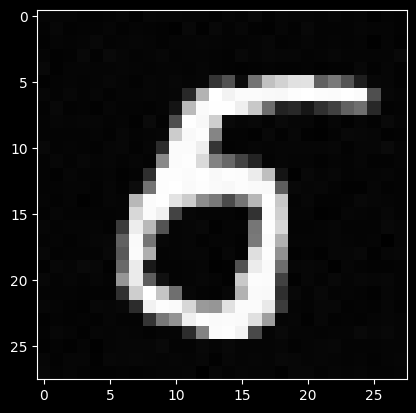

| Step: 8800 || Loss: 0.0363 || LR: 5.980290e-04 || dt: 718.46ms |
| Step: 8850 || Loss: 0.0253 || LR: 5.941558e-04 || dt: 19.22ms |
| Step: 8900 || Loss: 0.0338 || LR: 5.902768e-04 || dt: 18.68ms |
| Step: 8950 || Loss: 0.0325 || LR: 5.863922e-04 || dt: 19.26ms |
| Step: 9000 || Loss: 0.0266 || LR: 5.825022e-04 || dt: 19.55ms |
| Step: 9050 || Loss: 0.0353 || LR: 5.786070e-04 || dt: 19.30ms |
| Step: 9100 || Loss: 0.0467 || LR: 5.747070e-04 || dt: 19.50ms |
| Step: 9150 || Loss: 0.0462 || LR: 5.708023e-04 || dt: 19.55ms |
Generating images of [9]


100%|██████████| 399/399 [00:00<00:00, 587.44it/s]


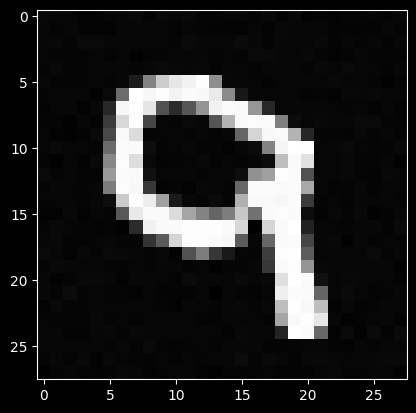

| Step: 9200 || Loss: 0.0368 || LR: 5.668931e-04 || dt: 732.39ms |
| Step: 9250 || Loss: 0.0547 || LR: 5.629799e-04 || dt: 19.30ms |
| Step: 9300 || Loss: 0.0350 || LR: 5.590626e-04 || dt: 19.30ms |
| Step: 9350 || Loss: 0.0320 || LR: 5.551417e-04 || dt: 21.63ms |
| Step: 9400 || Loss: 0.0408 || LR: 5.512174e-04 || dt: 19.36ms |
| Step: 9450 || Loss: 0.0455 || LR: 5.472899e-04 || dt: 19.92ms |
| Step: 9500 || Loss: 0.0321 || LR: 5.433594e-04 || dt: 19.65ms |
| Step: 9550 || Loss: 0.0322 || LR: 5.394263e-04 || dt: 19.67ms |
Generating images of [6]


100%|██████████| 399/399 [00:00<00:00, 584.88it/s]


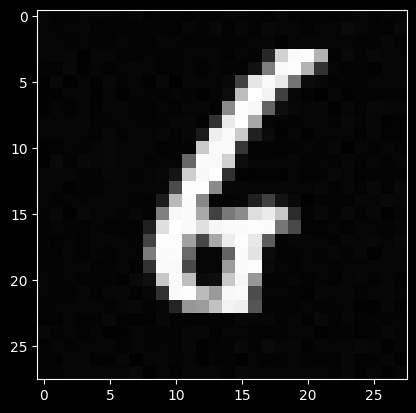

| Step: 9600 || Loss: 0.0336 || LR: 5.354906e-04 || dt: 734.62ms |
| Step: 9650 || Loss: 0.0376 || LR: 5.315528e-04 || dt: 19.47ms |
| Step: 9700 || Loss: 0.0340 || LR: 5.276130e-04 || dt: 19.72ms |
| Step: 9750 || Loss: 0.0330 || LR: 5.236715e-04 || dt: 19.31ms |
| Step: 9800 || Loss: 0.0279 || LR: 5.197285e-04 || dt: 19.29ms |
| Step: 9850 || Loss: 0.0316 || LR: 5.157843e-04 || dt: 20.49ms |
| Step: 9900 || Loss: 0.0334 || LR: 5.118391e-04 || dt: 19.53ms |
| Step: 9950 || Loss: 0.0377 || LR: 5.078931e-04 || dt: 19.61ms |
Generating images of [3]


100%|██████████| 399/399 [00:00<00:00, 596.34it/s]


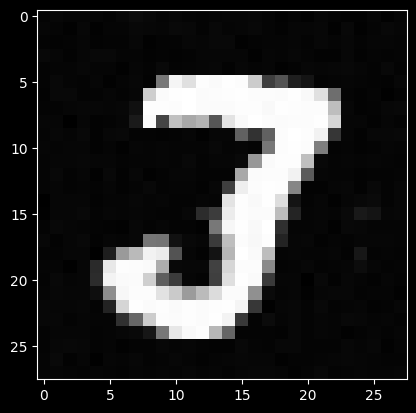

| Step: 10000 || Loss: 0.0373 || LR: 5.039467e-04 || dt: 721.41ms |
| Step: 10050 || Loss: 0.0434 || LR: 5.000000e-04 || dt: 18.73ms |
| Step: 10100 || Loss: 0.0360 || LR: 4.960533e-04 || dt: 19.85ms |
| Step: 10150 || Loss: 0.0336 || LR: 4.921069e-04 || dt: 19.01ms |
| Step: 10200 || Loss: 0.0405 || LR: 4.881609e-04 || dt: 19.47ms |
| Step: 10250 || Loss: 0.0337 || LR: 4.842157e-04 || dt: 19.53ms |
| Step: 10300 || Loss: 0.0356 || LR: 4.802715e-04 || dt: 19.13ms |
| Step: 10350 || Loss: 0.0351 || LR: 4.763285e-04 || dt: 19.23ms |
Generating images of [3]


100%|██████████| 399/399 [00:00<00:00, 526.76it/s]


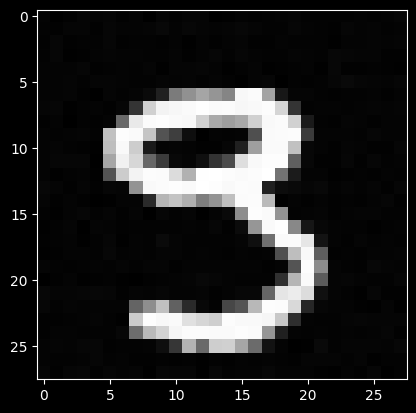

| Step: 10400 || Loss: 0.0327 || LR: 4.723870e-04 || dt: 808.51ms |
| Step: 10450 || Loss: 0.0503 || LR: 4.684472e-04 || dt: 18.88ms |
| Step: 10500 || Loss: 0.0302 || LR: 4.645094e-04 || dt: 19.37ms |
| Step: 10550 || Loss: 0.0352 || LR: 4.605737e-04 || dt: 19.29ms |
| Step: 10600 || Loss: 0.0358 || LR: 4.566406e-04 || dt: 19.41ms |
| Step: 10650 || Loss: 0.0479 || LR: 4.527101e-04 || dt: 19.34ms |
| Step: 10700 || Loss: 0.0541 || LR: 4.487826e-04 || dt: 19.15ms |
| Step: 10750 || Loss: 0.0362 || LR: 4.448583e-04 || dt: 19.85ms |
Generating images of [2]


100%|██████████| 399/399 [00:00<00:00, 557.82it/s]


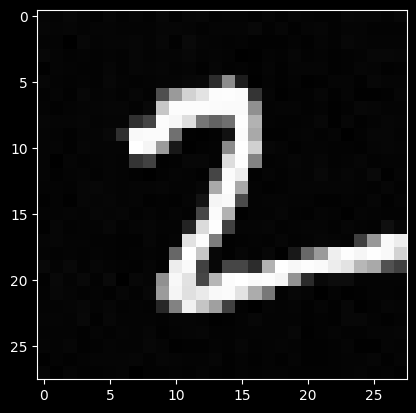

| Step: 10800 || Loss: 0.0345 || LR: 4.409374e-04 || dt: 767.69ms |
| Step: 10850 || Loss: 0.0442 || LR: 4.370201e-04 || dt: 18.46ms |
| Step: 10900 || Loss: 0.0334 || LR: 4.331069e-04 || dt: 18.88ms |
| Step: 10950 || Loss: 0.0414 || LR: 4.291977e-04 || dt: 19.07ms |
| Step: 11000 || Loss: 0.0284 || LR: 4.252930e-04 || dt: 19.84ms |
| Step: 11050 || Loss: 0.0299 || LR: 4.213930e-04 || dt: 19.44ms |
| Step: 11100 || Loss: 0.0374 || LR: 4.174978e-04 || dt: 19.61ms |
| Step: 11150 || Loss: 0.0329 || LR: 4.136078e-04 || dt: 19.67ms |
Generating images of [4]


100%|██████████| 399/399 [00:00<00:00, 592.04it/s]


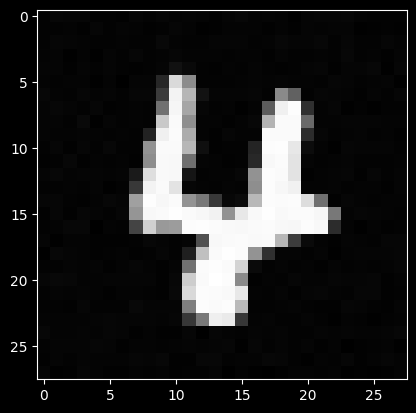

| Step: 11200 || Loss: 0.0343 || LR: 4.097232e-04 || dt: 724.53ms |
| Step: 11250 || Loss: 0.0380 || LR: 4.058442e-04 || dt: 18.98ms |
| Step: 11300 || Loss: 0.0347 || LR: 4.019710e-04 || dt: 19.18ms |
| Step: 11350 || Loss: 0.0419 || LR: 3.981040e-04 || dt: 19.46ms |
| Step: 11400 || Loss: 0.0306 || LR: 3.942433e-04 || dt: 18.98ms |
| Step: 11450 || Loss: 0.0302 || LR: 3.903892e-04 || dt: 19.42ms |
| Step: 11500 || Loss: 0.0367 || LR: 3.865419e-04 || dt: 19.04ms |
| Step: 11550 || Loss: 0.0319 || LR: 3.827017e-04 || dt: 19.31ms |
Generating images of [7]


100%|██████████| 399/399 [00:00<00:00, 584.29it/s]


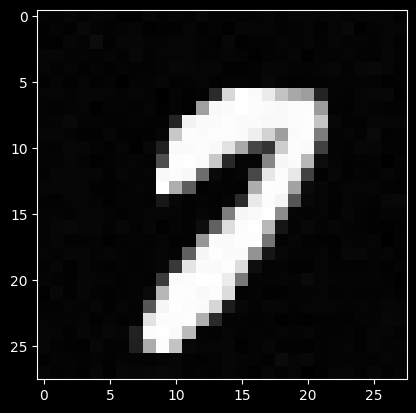

| Step: 11600 || Loss: 0.0300 || LR: 3.788689e-04 || dt: 736.74ms |
| Step: 11650 || Loss: 0.0370 || LR: 3.750435e-04 || dt: 19.71ms |
| Step: 11700 || Loss: 0.0395 || LR: 3.712260e-04 || dt: 19.49ms |
| Step: 11750 || Loss: 0.0310 || LR: 3.674164e-04 || dt: 19.36ms |
| Step: 11800 || Loss: 0.0268 || LR: 3.636152e-04 || dt: 19.37ms |
| Step: 11850 || Loss: 0.0309 || LR: 3.598224e-04 || dt: 19.09ms |
| Step: 11900 || Loss: 0.0313 || LR: 3.560383e-04 || dt: 18.99ms |
| Step: 11950 || Loss: 0.0335 || LR: 3.522633e-04 || dt: 19.13ms |
Generating images of [5]


100%|██████████| 399/399 [00:00<00:00, 588.73it/s]


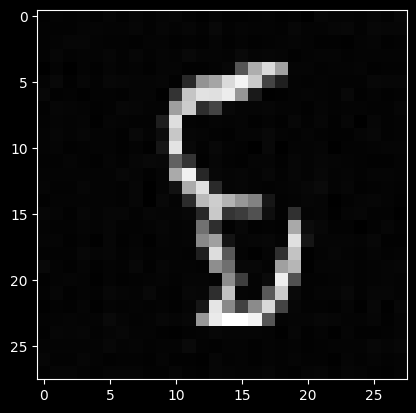

| Step: 12000 || Loss: 0.0627 || LR: 3.484974e-04 || dt: 729.88ms |
| Step: 12050 || Loss: 0.0280 || LR: 3.447410e-04 || dt: 19.32ms |
| Step: 12100 || Loss: 0.0504 || LR: 3.409942e-04 || dt: 18.79ms |
| Step: 12150 || Loss: 0.0356 || LR: 3.372574e-04 || dt: 19.15ms |
| Step: 12200 || Loss: 0.0330 || LR: 3.335307e-04 || dt: 19.53ms |
| Step: 12250 || Loss: 0.0384 || LR: 3.298143e-04 || dt: 19.06ms |
| Step: 12300 || Loss: 0.0324 || LR: 3.261086e-04 || dt: 19.12ms |
| Step: 12350 || Loss: 0.0363 || LR: 3.224137e-04 || dt: 19.02ms |
Generating images of [8]


100%|██████████| 399/399 [00:00<00:00, 587.22it/s]


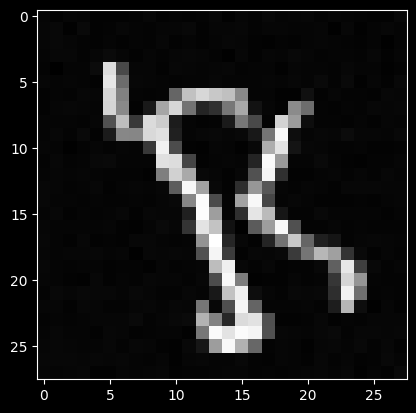

| Step: 12400 || Loss: 0.0370 || LR: 3.187299e-04 || dt: 731.39ms |
| Step: 12450 || Loss: 0.0433 || LR: 3.150574e-04 || dt: 18.89ms |
| Step: 12500 || Loss: 0.0441 || LR: 3.113963e-04 || dt: 19.43ms |
| Step: 12550 || Loss: 0.0329 || LR: 3.077471e-04 || dt: 19.19ms |
| Step: 12600 || Loss: 0.0361 || LR: 3.041098e-04 || dt: 20.20ms |
| Step: 12650 || Loss: 0.0352 || LR: 3.004847e-04 || dt: 18.51ms |
| Step: 12700 || Loss: 0.0322 || LR: 2.968721e-04 || dt: 18.83ms |
| Step: 12750 || Loss: 0.0296 || LR: 2.932721e-04 || dt: 19.19ms |
Generating images of [0]


100%|██████████| 399/399 [00:00<00:00, 573.89it/s]


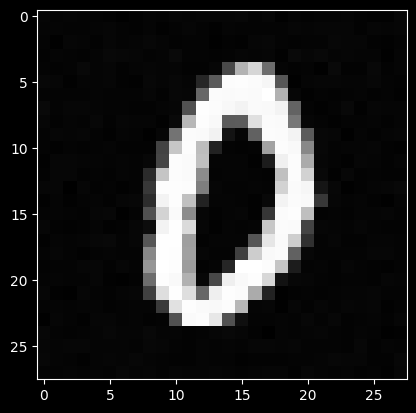

| Step: 12800 || Loss: 0.0220 || LR: 2.896850e-04 || dt: 749.10ms |
| Step: 12850 || Loss: 0.0282 || LR: 2.861110e-04 || dt: 18.97ms |
| Step: 12900 || Loss: 0.0395 || LR: 2.825503e-04 || dt: 19.67ms |
| Step: 12950 || Loss: 0.0405 || LR: 2.790032e-04 || dt: 18.89ms |
| Step: 13000 || Loss: 0.0475 || LR: 2.754698e-04 || dt: 18.96ms |
| Step: 13050 || Loss: 0.0348 || LR: 2.719504e-04 || dt: 18.47ms |
| Step: 13100 || Loss: 0.0344 || LR: 2.684453e-04 || dt: 19.27ms |
| Step: 13150 || Loss: 0.0265 || LR: 2.649545e-04 || dt: 19.68ms |
Generating images of [0]


100%|██████████| 399/399 [00:00<00:00, 592.58it/s]


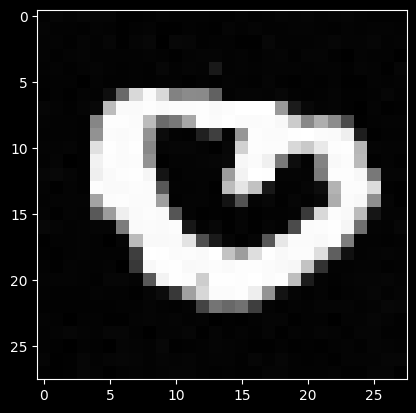

| Step: 13200 || Loss: 0.0330 || LR: 2.614784e-04 || dt: 723.82ms |
| Step: 13250 || Loss: 0.0293 || LR: 2.580172e-04 || dt: 18.55ms |
| Step: 13300 || Loss: 0.0304 || LR: 2.545710e-04 || dt: 18.57ms |
| Step: 13350 || Loss: 0.0447 || LR: 2.511402e-04 || dt: 19.17ms |
| Step: 13400 || Loss: 0.0412 || LR: 2.477248e-04 || dt: 19.33ms |
| Step: 13450 || Loss: 0.0292 || LR: 2.443252e-04 || dt: 19.05ms |
| Step: 13500 || Loss: 0.0324 || LR: 2.409415e-04 || dt: 19.04ms |
| Step: 13550 || Loss: 0.0280 || LR: 2.375739e-04 || dt: 19.02ms |
Generating images of [0]


100%|██████████| 399/399 [00:00<00:00, 570.72it/s]


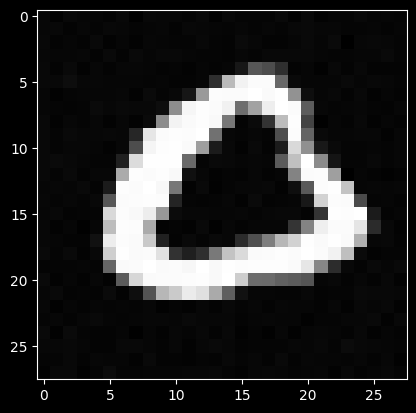

| Step: 13600 || Loss: 0.0365 || LR: 2.342227e-04 || dt: 752.22ms |
| Step: 13650 || Loss: 0.0344 || LR: 2.308880e-04 || dt: 18.86ms |
| Step: 13700 || Loss: 0.0374 || LR: 2.275702e-04 || dt: 19.46ms |
| Step: 13750 || Loss: 0.0347 || LR: 2.242692e-04 || dt: 18.23ms |
| Step: 13800 || Loss: 0.0289 || LR: 2.209855e-04 || dt: 20.10ms |
| Step: 13850 || Loss: 0.0317 || LR: 2.177192e-04 || dt: 19.10ms |
| Step: 13900 || Loss: 0.0306 || LR: 2.144704e-04 || dt: 20.40ms |
| Step: 13950 || Loss: 0.0329 || LR: 2.112394e-04 || dt: 19.06ms |
Generating images of [0]


100%|██████████| 399/399 [00:00<00:00, 578.11it/s]


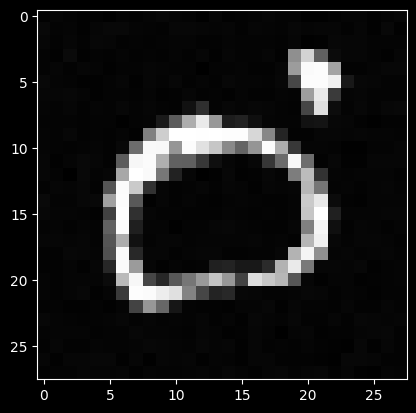

| Step: 14000 || Loss: 0.0535 || LR: 2.080264e-04 || dt: 742.53ms |
| Step: 14050 || Loss: 0.0358 || LR: 2.048317e-04 || dt: 18.56ms |
| Step: 14100 || Loss: 0.0299 || LR: 2.016553e-04 || dt: 18.74ms |
| Step: 14150 || Loss: 0.0334 || LR: 1.984974e-04 || dt: 19.14ms |
| Step: 14200 || Loss: 0.0394 || LR: 1.953584e-04 || dt: 19.56ms |
| Step: 14250 || Loss: 0.0303 || LR: 1.922384e-04 || dt: 19.52ms |
| Step: 14300 || Loss: 0.0291 || LR: 1.891375e-04 || dt: 18.95ms |
| Step: 14350 || Loss: 0.0334 || LR: 1.860560e-04 || dt: 19.08ms |
Generating images of [0]


100%|██████████| 399/399 [00:00<00:00, 583.72it/s]


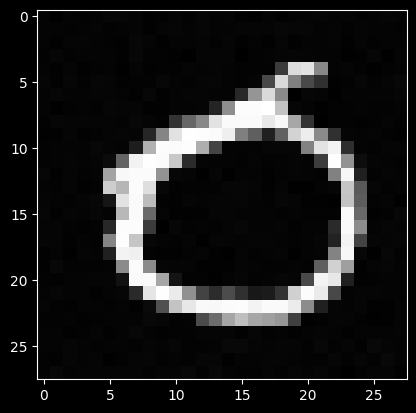

| Step: 14400 || Loss: 0.0315 || LR: 1.829941e-04 || dt: 739.23ms |
| Step: 14450 || Loss: 0.0312 || LR: 1.799519e-04 || dt: 18.78ms |
| Step: 14500 || Loss: 0.0344 || LR: 1.769296e-04 || dt: 18.89ms |
| Step: 14550 || Loss: 0.0348 || LR: 1.739275e-04 || dt: 19.16ms |
| Step: 14600 || Loss: 0.0265 || LR: 1.709457e-04 || dt: 19.19ms |
| Step: 14650 || Loss: 0.0329 || LR: 1.679844e-04 || dt: 19.04ms |
| Step: 14700 || Loss: 0.0316 || LR: 1.650438e-04 || dt: 18.70ms |
| Step: 14750 || Loss: 0.0344 || LR: 1.621241e-04 || dt: 18.80ms |
Generating images of [8]


100%|██████████| 399/399 [00:00<00:00, 581.01it/s]


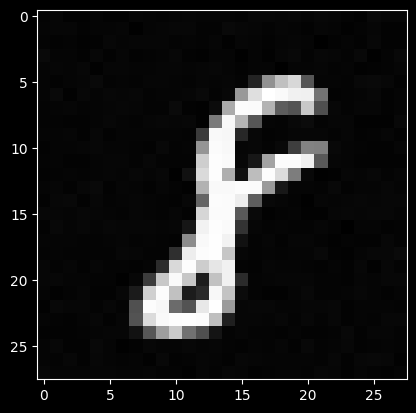

| Step: 14800 || Loss: 0.0331 || LR: 1.592254e-04 || dt: 740.85ms |
| Step: 14850 || Loss: 0.0333 || LR: 1.563479e-04 || dt: 19.24ms |
| Step: 14900 || Loss: 0.0343 || LR: 1.534919e-04 || dt: 19.81ms |
| Step: 14950 || Loss: 0.0468 || LR: 1.506574e-04 || dt: 19.81ms |
| Step: 15000 || Loss: 0.0254 || LR: 1.478447e-04 || dt: 19.75ms |
| Step: 15050 || Loss: 0.0337 || LR: 1.450540e-04 || dt: 19.43ms |
| Step: 15100 || Loss: 0.0337 || LR: 1.422854e-04 || dt: 18.63ms |
| Step: 15150 || Loss: 0.0387 || LR: 1.395390e-04 || dt: 19.37ms |
Generating images of [2]


100%|██████████| 399/399 [00:00<00:00, 597.79it/s]


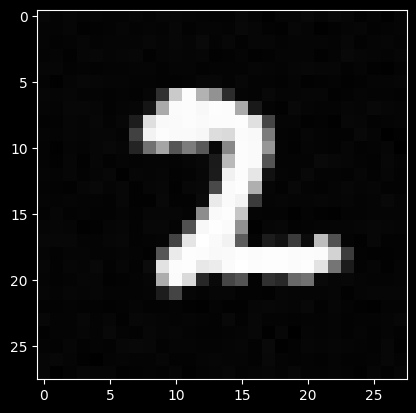

| Step: 15200 || Loss: 0.0367 || LR: 1.368151e-04 || dt: 718.70ms |
| Step: 15250 || Loss: 0.0287 || LR: 1.341139e-04 || dt: 18.69ms |
| Step: 15300 || Loss: 0.0566 || LR: 1.314354e-04 || dt: 19.56ms |
| Step: 15350 || Loss: 0.0318 || LR: 1.287799e-04 || dt: 19.42ms |
| Step: 15400 || Loss: 0.0337 || LR: 1.261475e-04 || dt: 19.10ms |
| Step: 15450 || Loss: 0.0469 || LR: 1.235385e-04 || dt: 19.10ms |
| Step: 15500 || Loss: 0.0316 || LR: 1.209528e-04 || dt: 19.99ms |
| Step: 15550 || Loss: 0.0335 || LR: 1.183908e-04 || dt: 17.96ms |
Generating images of [3]


100%|██████████| 399/399 [00:00<00:00, 563.76it/s]


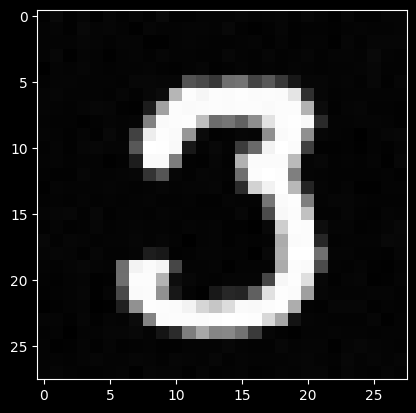

| Step: 15600 || Loss: 0.0471 || LR: 1.158526e-04 || dt: 763.49ms |
| Step: 15650 || Loss: 0.0284 || LR: 1.133383e-04 || dt: 19.15ms |
| Step: 15700 || Loss: 0.0339 || LR: 1.108481e-04 || dt: 19.74ms |
| Step: 15750 || Loss: 0.0269 || LR: 1.083822e-04 || dt: 19.51ms |
| Step: 15800 || Loss: 0.0288 || LR: 1.059406e-04 || dt: 20.02ms |
| Step: 15850 || Loss: 0.0392 || LR: 1.035236e-04 || dt: 17.98ms |
| Step: 15900 || Loss: 0.0354 || LR: 1.011313e-04 || dt: 23.70ms |
| Step: 15950 || Loss: 0.0329 || LR: 9.876389e-05 || dt: 18.39ms |
Generating images of [4]


100%|██████████| 399/399 [00:00<00:00, 578.43it/s]


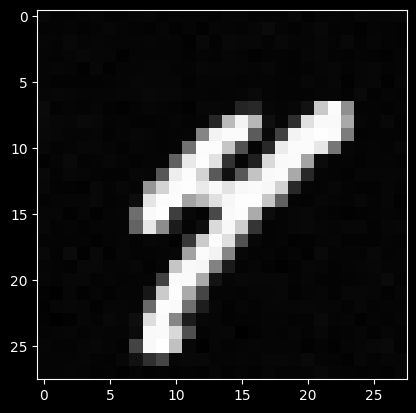

| Step: 16000 || Loss: 0.0309 || LR: 9.642145e-05 || dt: 744.13ms |
| Step: 16050 || Loss: 0.0487 || LR: 9.410415e-05 || dt: 18.90ms |
| Step: 16100 || Loss: 0.0266 || LR: 9.181214e-05 || dt: 18.45ms |
| Step: 16150 || Loss: 0.0280 || LR: 8.954556e-05 || dt: 19.12ms |
| Step: 16200 || Loss: 0.0305 || LR: 8.730456e-05 || dt: 21.61ms |
| Step: 16250 || Loss: 0.0396 || LR: 8.508927e-05 || dt: 20.59ms |
| Step: 16300 || Loss: 0.0482 || LR: 8.289983e-05 || dt: 18.23ms |
| Step: 16350 || Loss: 0.0315 || LR: 8.073638e-05 || dt: 17.91ms |
Generating images of [5]


100%|██████████| 399/399 [00:00<00:00, 603.08it/s]


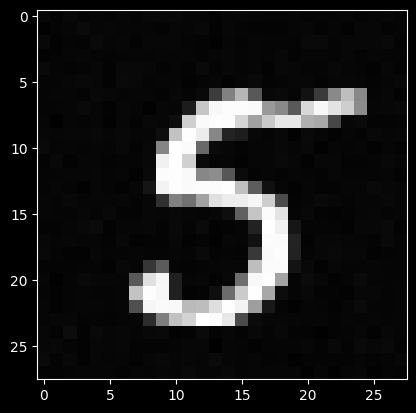

| Step: 16400 || Loss: 0.0370 || LR: 7.859905e-05 || dt: 714.42ms |
| Step: 16450 || Loss: 0.0333 || LR: 7.648798e-05 || dt: 18.16ms |
| Step: 16500 || Loss: 0.0321 || LR: 7.440330e-05 || dt: 17.63ms |
| Step: 16550 || Loss: 0.0279 || LR: 7.234513e-05 || dt: 17.97ms |
| Step: 16600 || Loss: 0.0368 || LR: 7.031361e-05 || dt: 18.20ms |
| Step: 16650 || Loss: 0.0531 || LR: 6.830886e-05 || dt: 19.25ms |
| Step: 16700 || Loss: 0.0471 || LR: 6.633101e-05 || dt: 19.21ms |
| Step: 16750 || Loss: 0.0449 || LR: 6.438018e-05 || dt: 17.98ms |
Generating images of [9]


100%|██████████| 399/399 [00:00<00:00, 617.91it/s]


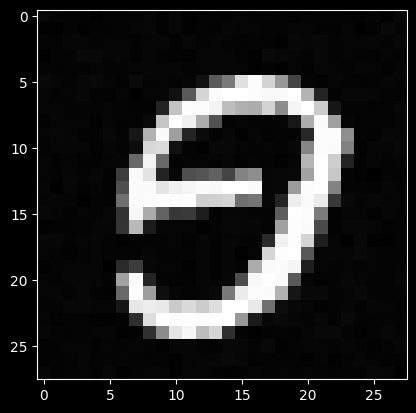

| Step: 16800 || Loss: 0.0307 || LR: 6.245649e-05 || dt: 695.85ms |
| Step: 16850 || Loss: 0.0252 || LR: 6.056006e-05 || dt: 18.55ms |
| Step: 16900 || Loss: 0.0310 || LR: 5.869101e-05 || dt: 17.92ms |
| Step: 16950 || Loss: 0.0323 || LR: 5.684946e-05 || dt: 19.06ms |
| Step: 17000 || Loss: 0.0239 || LR: 5.503552e-05 || dt: 18.86ms |
| Step: 17050 || Loss: 0.0274 || LR: 5.324930e-05 || dt: 22.37ms |
| Step: 17100 || Loss: 0.0387 || LR: 5.149092e-05 || dt: 19.87ms |
| Step: 17150 || Loss: 0.0308 || LR: 4.976048e-05 || dt: 20.24ms |
Generating images of [3]


100%|██████████| 399/399 [00:00<00:00, 586.90it/s]


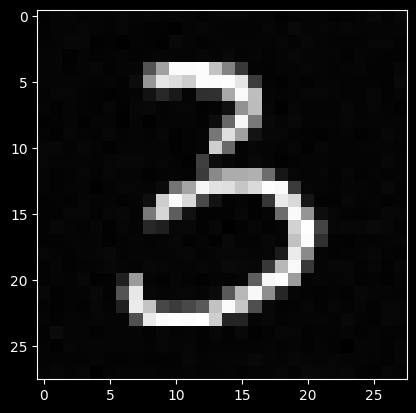

| Step: 17200 || Loss: 0.0318 || LR: 4.805810e-05 || dt: 734.98ms |
| Step: 17250 || Loss: 0.0336 || LR: 4.638387e-05 || dt: 19.16ms |
| Step: 17300 || Loss: 0.0453 || LR: 4.473791e-05 || dt: 18.54ms |
| Step: 17350 || Loss: 0.0365 || LR: 4.312032e-05 || dt: 18.97ms |
| Step: 17400 || Loss: 0.0481 || LR: 4.153119e-05 || dt: 19.09ms |
| Step: 17450 || Loss: 0.0408 || LR: 3.997062e-05 || dt: 20.01ms |
| Step: 17500 || Loss: 0.0336 || LR: 3.843872e-05 || dt: 19.93ms |
| Step: 17550 || Loss: 0.0365 || LR: 3.693558e-05 || dt: 19.76ms |
Generating images of [5]


100%|██████████| 399/399 [00:00<00:00, 557.84it/s]


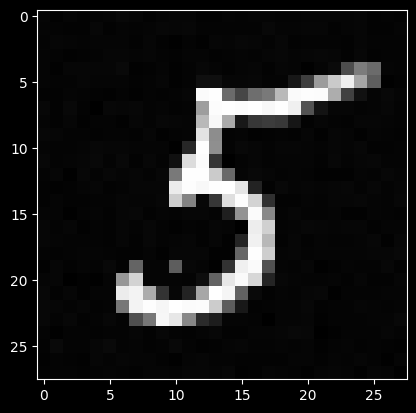

| Step: 17600 || Loss: 0.0298 || LR: 3.546128e-05 || dt: 766.32ms |
| Step: 17650 || Loss: 0.0292 || LR: 3.401594e-05 || dt: 19.11ms |
| Step: 17700 || Loss: 0.0259 || LR: 3.259962e-05 || dt: 19.75ms |
| Step: 17750 || Loss: 0.0509 || LR: 3.121243e-05 || dt: 20.03ms |
| Step: 17800 || Loss: 0.0234 || LR: 2.985444e-05 || dt: 19.98ms |
| Step: 17850 || Loss: 0.0258 || LR: 2.852575e-05 || dt: 19.63ms |
| Step: 17900 || Loss: 0.0412 || LR: 2.722644e-05 || dt: 19.82ms |
| Step: 17950 || Loss: 0.0265 || LR: 2.595658e-05 || dt: 18.74ms |
Generating images of [9]


100%|██████████| 399/399 [00:00<00:00, 575.37it/s]


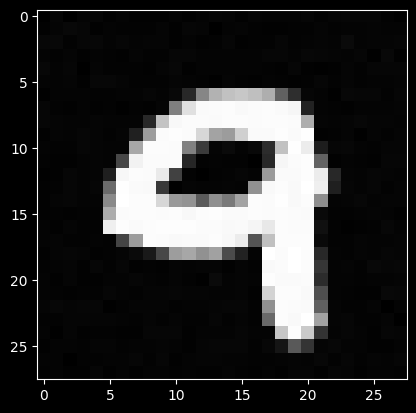

| Step: 18000 || Loss: 0.0266 || LR: 2.471626e-05 || dt: 747.01ms |
| Step: 18050 || Loss: 0.0319 || LR: 2.350555e-05 || dt: 19.52ms |
| Step: 18100 || Loss: 0.0447 || LR: 2.232452e-05 || dt: 19.72ms |
| Step: 18150 || Loss: 0.0472 || LR: 2.117327e-05 || dt: 18.91ms |
| Step: 18200 || Loss: 0.0395 || LR: 2.005184e-05 || dt: 19.37ms |
| Step: 18250 || Loss: 0.0334 || LR: 1.896032e-05 || dt: 18.95ms |
| Step: 18300 || Loss: 0.0291 || LR: 1.789877e-05 || dt: 19.82ms |
| Step: 18350 || Loss: 0.0336 || LR: 1.686726e-05 || dt: 19.31ms |
Generating images of [7]


100%|██████████| 399/399 [00:00<00:00, 600.20it/s]


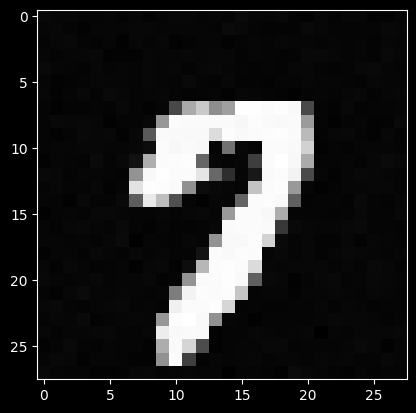

| Step: 18400 || Loss: 0.0383 || LR: 1.586585e-05 || dt: 716.35ms |
| Step: 18450 || Loss: 0.0451 || LR: 1.489460e-05 || dt: 19.44ms |
| Step: 18500 || Loss: 0.0362 || LR: 1.395358e-05 || dt: 19.57ms |
| Step: 18550 || Loss: 0.0347 || LR: 1.304285e-05 || dt: 19.01ms |
| Step: 18600 || Loss: 0.0484 || LR: 1.216245e-05 || dt: 19.87ms |
| Step: 18650 || Loss: 0.0327 || LR: 1.131245e-05 || dt: 19.57ms |
| Step: 18700 || Loss: 0.0356 || LR: 1.049290e-05 || dt: 19.32ms |
| Step: 18750 || Loss: 0.0332 || LR: 9.703844e-06 || dt: 19.97ms |
Generating images of [7]


100%|██████████| 399/399 [00:00<00:00, 564.40it/s]


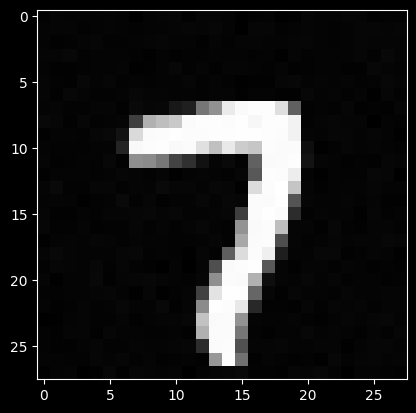

| Step: 18800 || Loss: 0.0333 || LR: 8.945340e-06 || dt: 759.28ms |
| Step: 18850 || Loss: 0.0352 || LR: 8.217431e-06 || dt: 19.00ms |
| Step: 18900 || Loss: 0.0263 || LR: 7.520164e-06 || dt: 28.34ms |
| Step: 18950 || Loss: 0.0329 || LR: 6.853581e-06 || dt: 20.07ms |
| Step: 19000 || Loss: 0.0309 || LR: 6.217724e-06 || dt: 18.66ms |
| Step: 19050 || Loss: 0.0316 || LR: 5.612633e-06 || dt: 19.63ms |
| Step: 19100 || Loss: 0.0760 || LR: 5.038345e-06 || dt: 19.97ms |
| Step: 19150 || Loss: 0.0433 || LR: 4.494896e-06 || dt: 19.85ms |
Generating images of [6]


100%|██████████| 399/399 [00:00<00:00, 571.39it/s]


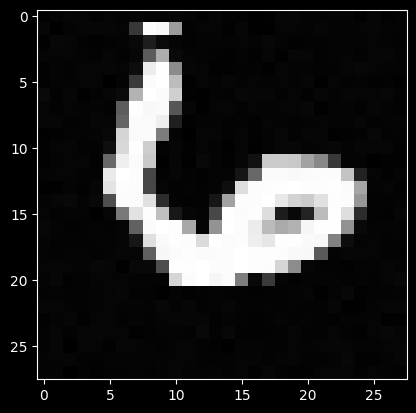

| Step: 19200 || Loss: 0.0304 || LR: 3.982321e-06 || dt: 751.63ms |
| Step: 19250 || Loss: 0.0370 || LR: 3.500650e-06 || dt: 19.51ms |
| Step: 19300 || Loss: 0.0287 || LR: 3.049915e-06 || dt: 19.60ms |
| Step: 19350 || Loss: 0.0316 || LR: 2.630142e-06 || dt: 18.86ms |
| Step: 19400 || Loss: 0.0350 || LR: 2.241359e-06 || dt: 19.08ms |
| Step: 19450 || Loss: 0.0373 || LR: 1.883589e-06 || dt: 19.63ms |
| Step: 19500 || Loss: 0.0341 || LR: 1.556855e-06 || dt: 19.49ms |
| Step: 19550 || Loss: 0.0338 || LR: 1.261177e-06 || dt: 18.98ms |
Generating images of [0]


100%|██████████| 399/399 [00:00<00:00, 589.63it/s]


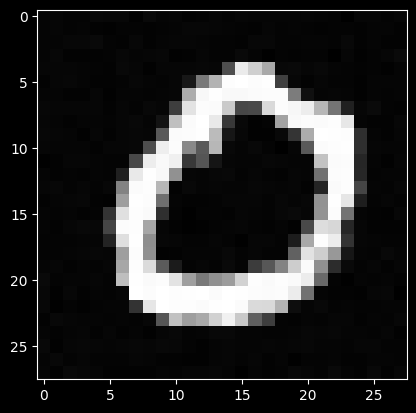

| Step: 19600 || Loss: 0.0259 || LR: 9.965733e-07 || dt: 727.22ms |
| Step: 19650 || Loss: 0.0335 || LR: 7.630609e-07 || dt: 19.69ms |
| Step: 19700 || Loss: 0.0329 || LR: 5.606540e-07 || dt: 19.07ms |
| Step: 19750 || Loss: 0.0289 || LR: 3.893653e-07 || dt: 19.79ms |
| Step: 19800 || Loss: 0.0368 || LR: 2.492054e-07 || dt: 20.02ms |
| Step: 19850 || Loss: 0.0353 || LR: 1.401832e-07 || dt: 19.45ms |
| Step: 19900 || Loss: 0.0310 || LR: 6.230524e-08 || dt: 18.92ms |
| Step: 19950 || Loss: 0.0331 || LR: 1.557655e-08 || dt: 19.52ms |
Generating images of [9]


100%|██████████| 399/399 [00:00<00:00, 596.98it/s]


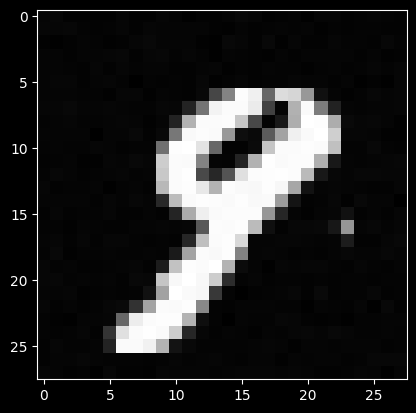

In [25]:
def train(model:nn.Module):
    t0 = time.time()
    losses = []
    for step in range(0, config.num_steps):
        lr = get_lr(step)
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr

        if (step % config.eval_freq == 0 and step > 0) or step == config.num_steps-1:
            gen_image = evaluate(model)
            plt.imshow(gen_image.numpy(), cmap="gray")
            plt.show()

        optimizer.zero_grad(set_to_none=True)
        X_batch, y_batch = next(train_iterator)

        timesteps = torch.randint(
            size=(X_batch.shape[0],), low=0, high=config.num_timesteps, device=config.device
        )
        noisy_image_timestep, noise_true = diff_utils.noisy_it(X_batch, timesteps)
        
        with ctx:
            noise_pred = model(noisy_image_timestep["noisy_images"], noisy_image_timestep["timesteps"], y_batch)
            loss = F.mse_loss(noise_pred, noise_true)
        loss.backward()
        if config.clipnorm is not None:
            norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=config.clipnorm, error_if_nonfinite=True)
        optimizer.step()

        t1 = time.time()
        dt = t1-t0
        t0 = t1
        lossf = loss.item()
        if step % config.log_interval == 0:
            print(
                f"| Step: {step} || Loss: {lossf:.4f} |"
                f"| LR: {lr:e} || dt: {dt*1000:.2f}ms |", end="")
            print(f"| Norm: {norm:.4f} |" if config.clipnorm is not None else "")
        losses.append(lossf)
    return losses

losses = train(model)

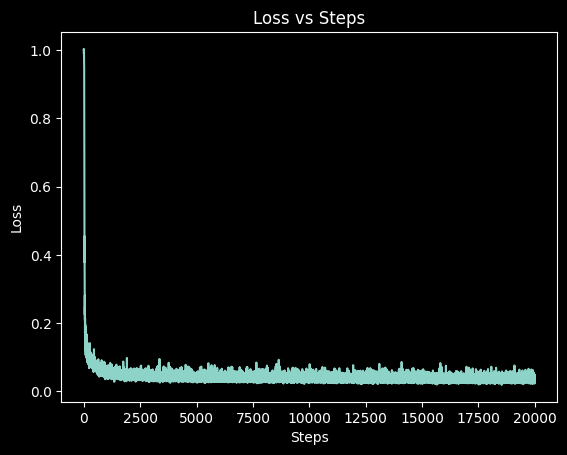

In [26]:
plt.plot(losses)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Loss vs Steps")
plt.show()

Generating images of [0]


100%|██████████| 399/399 [00:00<00:00, 516.63it/s]


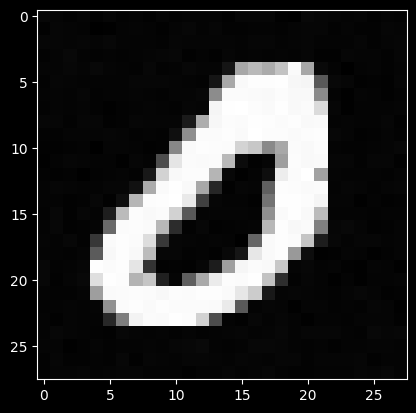

Generating images of [1]


100%|██████████| 399/399 [00:00<00:00, 595.94it/s]


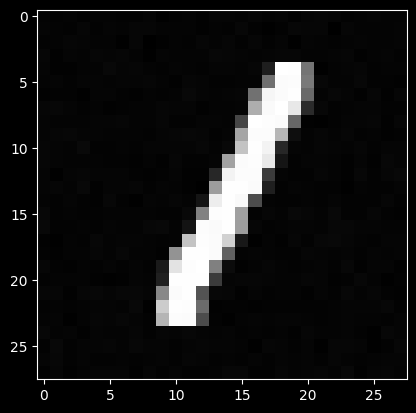

Generating images of [2]


100%|██████████| 399/399 [00:00<00:00, 586.76it/s]


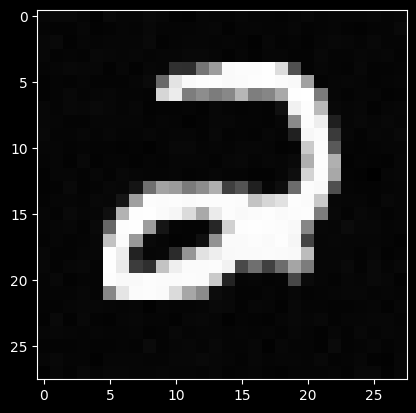

Generating images of [3]


100%|██████████| 399/399 [00:00<00:00, 573.61it/s]


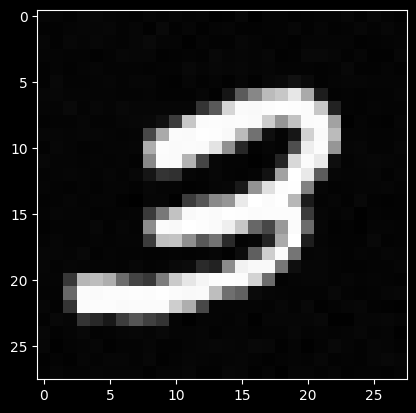

Generating images of [4]


100%|██████████| 399/399 [00:00<00:00, 591.45it/s]


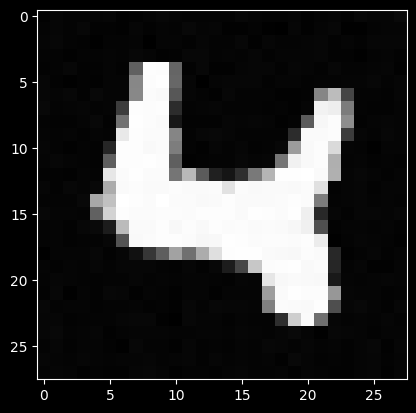

Generating images of [5]


100%|██████████| 399/399 [00:00<00:00, 581.44it/s]


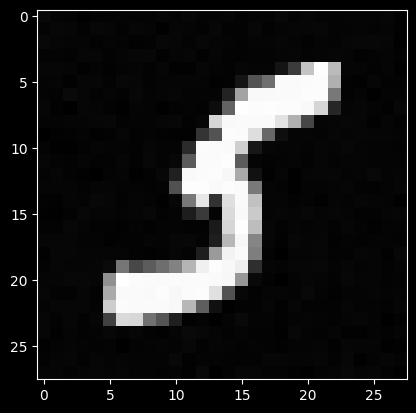

Generating images of [6]


100%|██████████| 399/399 [00:00<00:00, 582.92it/s]


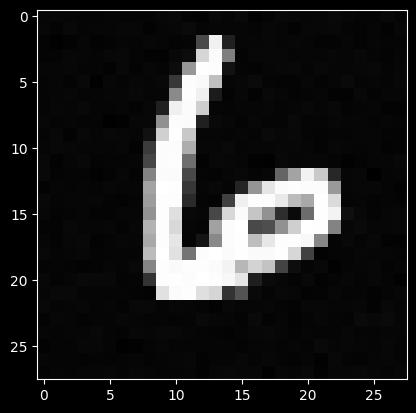

Generating images of [7]


100%|██████████| 399/399 [00:00<00:00, 594.05it/s]


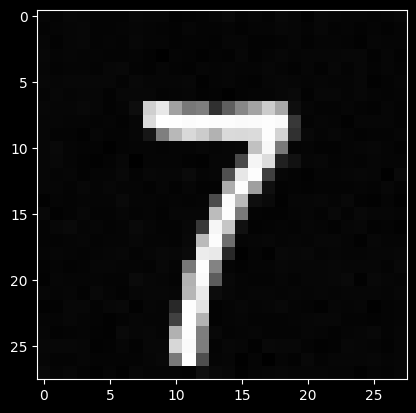

Generating images of [8]


100%|██████████| 399/399 [00:00<00:00, 591.85it/s]


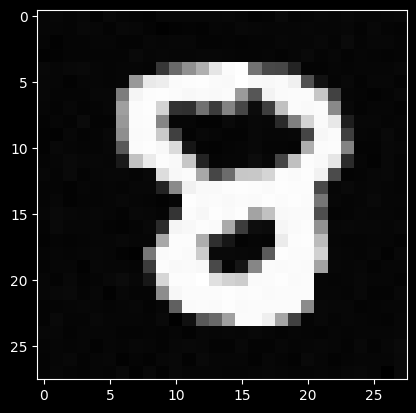

Generating images of [9]


100%|██████████| 399/399 [00:00<00:00, 589.50it/s]


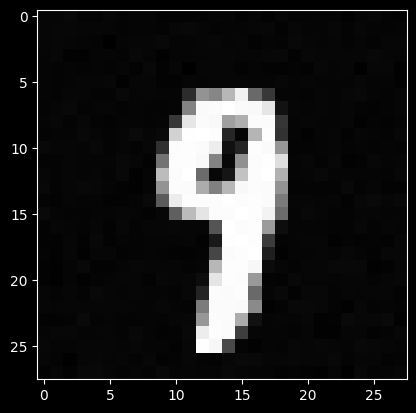

In [31]:
for i in range(10):
    gen_image = diff_utils.generate(model=model, num_samples=1, labels=[i])
    plt.imshow(gen_image.squeeze().cpu().numpy(), cmap="gray")
    plt.show()